In [1]:
pip install scipy numpy matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
from scipy.io import loadmat
import numpy as np

# Load the .mat file
data = loadmat("KukaDirectDynamics.mat")  # replace with your path if needed

# Find all trajectory variables starting with 'kukatraj'
trajectory_keys = [key for key in data if key.startswith("kukatraj") and isinstance(data[key], np.ndarray)]

# Extract and store each trajectory (make sure they are 2D)
trajectory_data = []
for key in trajectory_keys:
    traj = np.squeeze(data[key])  # remove singleton dimensions
    if traj.ndim == 2:            # keep only valid 2D trajectories
        trajectory_data.append(traj)

# Combine all trajectory arrays into one single dataset
all_data = np.concatenate(trajectory_data, axis=0)

# Preview
print("Keys found:", trajectory_keys)
print("Combined data shape:", all_data.shape)
print("First 3 samples:\n", all_data[:3])


Keys found: ['kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9']
Combined data shape: (20068, 35)
First 3 samples:
 [[  0.26213163   0.24401024  -0.34289578   1.76106691  -0.06711061
   -1.61111581  -1.66310751   0.           0.           0.
    0.           0.           0.           0.          -0.36000001
   10.80000019   1.38       -21.5          0.14         0.08
    0.34999999   0.26213163   0.24401024  -0.34289578   1.76106691
   -0.06711061  -1.61111581  -1.66310751   0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.26213163   0.24401024  -0.34289578   1.76106691  -0.06711061
   -1.61111581  -1.66310751   0.           0.           0.
    0.           0.           0.           0.          -0.36000001
   10.80000019   1.38       -21.5          0.14         0.08
    0.34999999   0.26213163   0.24401024  -0.34289578   1.76106691
   -0.06711061  -1.61111581  -1.6631

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- Step 2A: Normalize all features ---
scaler = StandardScaler()
normalized_data = scaler.fit_transform(all_data)

# --- Step 2B: Create time-windowed sequences ---
window_size = 10  # 10 time steps input → 1 time step output
X, y = [], []

for i in range(len(normalized_data) - window_size):
    X.append(normalized_data[i:i+window_size])
    y.append(normalized_data[i+window_size])  # next step prediction

X = np.array(X)
y = np.array(y)

# --- Step 2C: Train/Val/Test split ---
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=69)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=55)

# --- Shape Summary ---
print("Input Shape (X):", X.shape)
print("Output Shape (y):", y.shape)
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Input Shape (X): (20058, 10, 35)
Output Shape (y): (20058, 35)
Train: (14040, 10, 35)
Validation: (3009, 10, 35)
Test: (3009, 10, 35)


In [4]:
# --- PyTorch bootstrap ---
try:
    import torch
except ModuleNotFoundError:
    # If this prints, install PyTorch in your environment, e.g.:
    # pip install torch --quiet
    # (or pick the CUDA build from pytorch.org for your GPU)
    raise

import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [5]:
def to_tensor(x, device=device):
    x = np.asarray(x, dtype=np.float32, order="C")   # ensure float32 + contiguous
    return torch.from_numpy(x).to(device)            # zero-copy from numpy

X_train_tensor = to_tensor(X_train)
y_train_tensor = to_tensor(y_train)
X_val_tensor   = to_tensor(X_val)
y_val_tensor   = to_tensor(y_val)
X_test_tensor  = to_tensor(X_test)
y_test_tensor  = to_tensor(y_test)

for name, t in {"Xtr":X_train_tensor, "ytr":y_train_tensor,
                "Xva":X_val_tensor,   "yva":y_val_tensor}.items():
    print(f"{name}: {tuple(t.shape)} {t.dtype} on {t.device}")


Xtr: (14040, 10, 35) torch.float32 on cpu
ytr: (14040, 35) torch.float32 on cpu
Xva: (3009, 10, 35) torch.float32 on cpu
yva: (3009, 35) torch.float32 on cpu


In [6]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor,   y_val_tensor)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,  drop_last=True)
val_dl   = DataLoader(val_ds,   batch_size=64, shuffle=False, drop_last=False)


In [7]:
# Convert datasets to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [8]:
batch_size = 64

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)


In [9]:
# --- PyTorch imports (run this once per kernel) ---
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# --- GRU model ---
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.gru = nn.GRU(
            input_dim, hidden_dim,
            num_layers=num_layers,
            dropout=(dropout if num_layers > 1 else 0.0),
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None):
        # x: (batch, seq_len, input_dim)
        out, h = self.gru(x, h0)        # out -> (batch, seq_len, hidden_dim)
        y = self.fc(out[:, -1, :])      # use last time-step
        return y


Using: cpu


In [10]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])  # use output at final time step


In [11]:
input_dim = X_train.shape[2]
hidden_dim = 64
output_dim = y_train.shape[1]

model = GRUNet(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_preds = model(val_x)
            val_loss += criterion(val_preds, val_y).item()

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {running_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/20 | Train Loss: 40.2009 | Val Loss: 2.2421
Epoch 2/20 | Train Loss: 7.5542 | Val Loss: 1.2724
Epoch 3/20 | Train Loss: 5.0295 | Val Loss: 0.9803
Epoch 4/20 | Train Loss: 4.1349 | Val Loss: 0.8558
Epoch 5/20 | Train Loss: 3.7626 | Val Loss: 0.7926
Epoch 6/20 | Train Loss: 3.4743 | Val Loss: 0.7577
Epoch 7/20 | Train Loss: 3.2855 | Val Loss: 0.7152
Epoch 8/20 | Train Loss: 3.1649 | Val Loss: 0.6999
Epoch 9/20 | Train Loss: 3.0599 | Val Loss: 0.6773
Epoch 10/20 | Train Loss: 2.9760 | Val Loss: 0.6613
Epoch 11/20 | Train Loss: 2.9113 | Val Loss: 0.6329
Epoch 12/20 | Train Loss: 2.8336 | Val Loss: 0.6309
Epoch 13/20 | Train Loss: 2.8121 | Val Loss: 0.6245
Epoch 14/20 | Train Loss: 2.7326 | Val Loss: 0.6180
Epoch 15/20 | Train Loss: 2.6877 | Val Loss: 0.5957
Epoch 16/20 | Train Loss: 2.6606 | Val Loss: 0.5897
Epoch 17/20 | Train Loss: 2.6159 | Val Loss: 0.5874
Epoch 18/20 | Train Loss: 2.6203 | Val Loss: 0.5795
Epoch 19/20 | Train Loss: 2.5641 | Val Loss: 0.5600
Epoch 20/20 | Train 

In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor).numpy()
    test_true = y_test_tensor.numpy()

# Calculate RMSE
gru_rmse = np.sqrt(mean_squared_error(test_true, test_preds))
print(f" GRU Test RMSE: {gru_rmse:.4f}")


 GRU Test RMSE: 0.1087


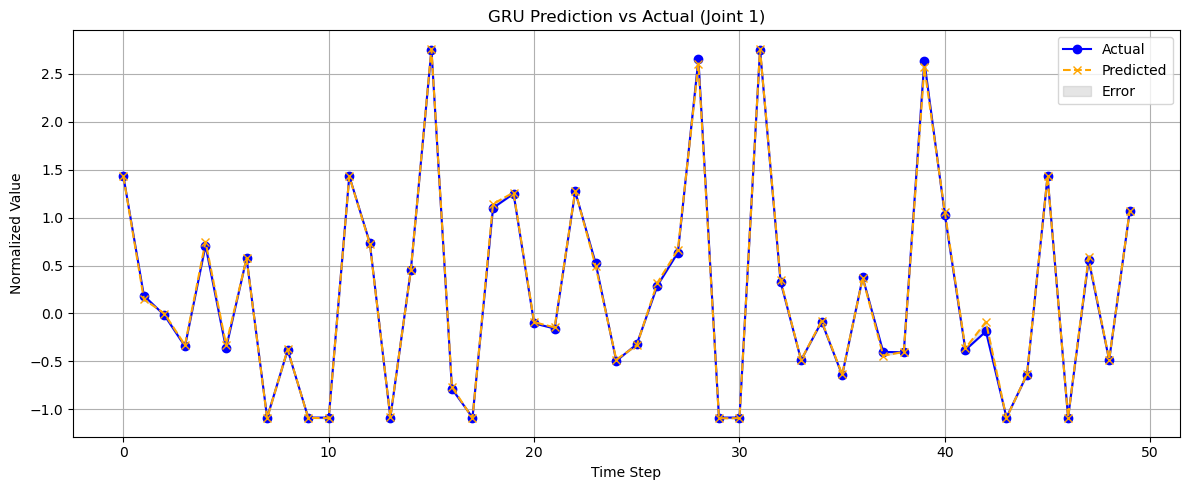

In [14]:
import matplotlib.pyplot as plt

joint_idx = 0  # index for Joint 1
num_samples = 50

plt.figure(figsize=(12, 5))
plt.plot(test_true[:num_samples, joint_idx], label='Actual', color='blue', marker='o')
plt.plot(test_preds[:num_samples, joint_idx], label='Predicted', color='orange', linestyle='--', marker='x')
plt.fill_between(range(num_samples), 
                 test_true[:num_samples, joint_idx], 
                 test_preds[:num_samples, joint_idx], 
                 color='gray', alpha=0.2, label='Error')

plt.title("GRU Prediction vs Actual (Joint 1)")
plt.xlabel("Time Step")
plt.ylabel("Normalized Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
from scipy.io import loadmat
import numpy as np

# Load the file
data = loadmat('KukaDirectDynamics.mat')  # or 'BaxterDirectDynamics.mat'

# Check available variables
print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


In [16]:
['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj2', ..., 'kukatraj10']


['__header__',
 '__version__',
 '__globals__',
 'kukatraj1',
 'kukatraj2',
 Ellipsis,
 'kukatraj10']

In [17]:
traj1 = data['kukatraj1']
print(traj1.shape)


(1814, 35)


In [18]:
from scipy.io import loadmat
import numpy as np

# Load the file
data = loadmat('KukaDirectDynamics.mat')

# Extract all trajectory arrays dynamically
trajectory_data = []

for key in data:
    if key.startswith('kukatraj') and isinstance(data[key], np.ndarray):
        traj = np.squeeze(data[key])
        if traj.ndim == 2:
            trajectory_data.append(traj)

# Combine them
all_data = np.concatenate(trajectory_data, axis=0)


In [19]:
np.isnan(all_data).sum(), np.isinf(all_data).sum()


(0, 0)

In [20]:
np.all(all_data == all_data[0, :], axis=0)


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [21]:
from scipy.io import loadmat
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- Load the .mat file ---
data = loadmat('KukaDirectDynamics.mat')  # Replace with 'BaxterDirectDynamics.mat' if needed

# --- Combine kukatraj data ---
trajectory_data = []

for key in data:
    if key.startswith('kukatraj') and isinstance(data[key], np.ndarray):
        traj = np.squeeze(data[key])
        if traj.ndim == 2:
            trajectory_data.append(traj)

all_data = np.concatenate(trajectory_data, axis=0)

# --- Check for missing or infinite values (optional) ---
print("NaNs:", np.isnan(all_data).sum(), "Infs:", np.isinf(all_data).sum())

# --- Normalize the data ---
scaler = StandardScaler()
normalized_data = scaler.fit_transform(all_data)

# --- Create input-output sequences ---
window_size = 10
X, y = [], []

for i in range(len(normalized_data) - window_size):
    X.append(normalized_data[i:i+window_size])
    y.append(normalized_data[i+window_size])

X = np.array(X)
y = np.array(y)

# --- Train/Val/Test split ---
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=66)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=98)

# --- Output s


NaNs: 0 Infs: 0


In [22]:
# STEP 5: Test Evaluation
from sklearn.metrics import mean_squared_error

model.eval()
with torch.no_grad():
    test_pred = model(X_test_tensor).numpy()
    test_true = y_test_tensor.numpy()


In [23]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error  

rmse = np.sqrt(mean_squared_error(test_true, test_pred))
print(f"\n GRU Test RMSE: {rmse:.4f}")





 GRU Test RMSE: 0.1087


In [26]:
import numpy as np

class SimpleESN:
    def __init__(self, input_dim, reservoir_size, output_dim, spectral_radius=0.95, leak_rate=0.3, seed=42):
        np.random.seed(seed)
        self.input_dim = input_dim
        self.reservoir_size = reservoir_size
        self.output_dim = output_dim
        self.spectral_radius = spectral_radius
        self.leak_rate = leak_rate

        self.Win = np.random.uniform(-1, 1, (reservoir_size, input_dim))
        W = np.random.uniform(-1, 1, (reservoir_size, reservoir_size))
        eigval = max(abs(np.linalg.eigvals(W)))
        self.W = W * (spectral_radius / eigval)

        self.state = np.zeros((reservoir_size,))
        self.Wout = None

    def _update(self, u):
        pre_a_


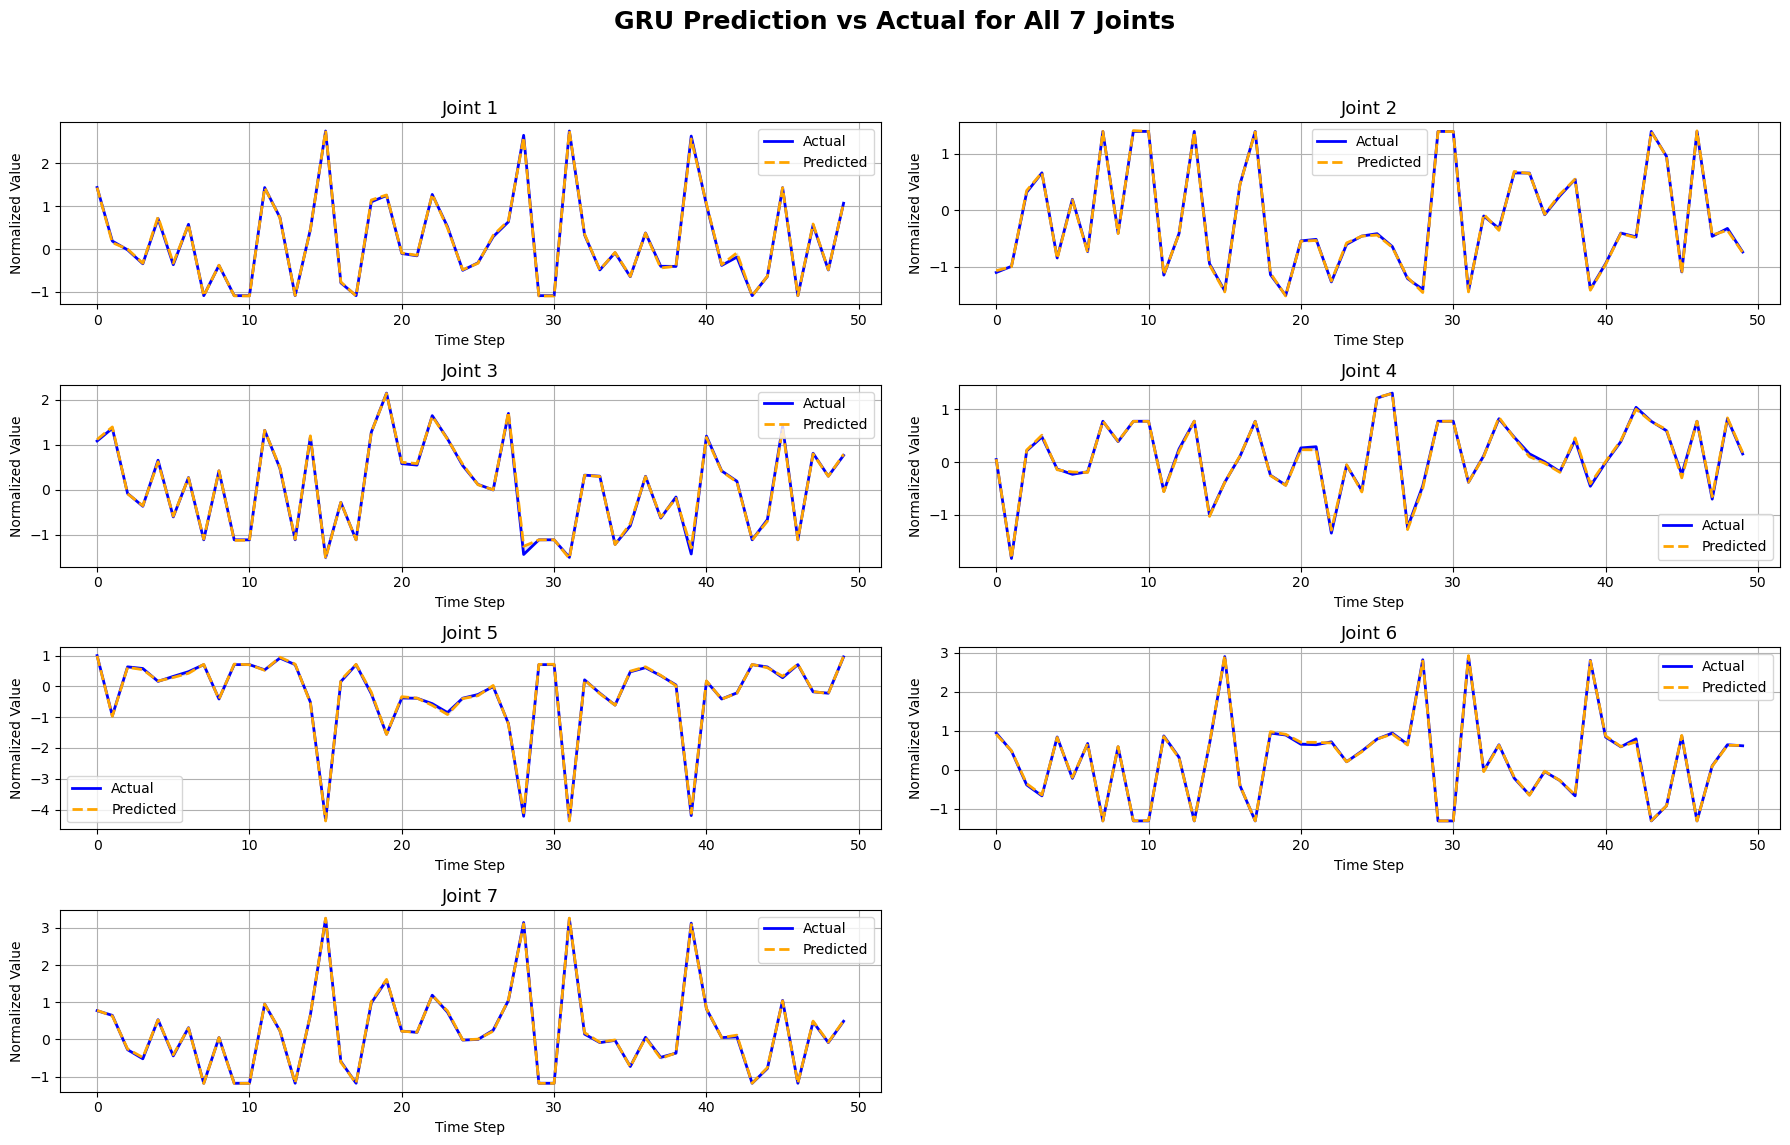

In [27]:
import matplotlib.pyplot as plt

joints_to_plot = list(range(7))  # joints 0 to 6
num_samples = 50

plt.figure(figsize=(18, 12))
for i, joint_idx in enumerate(joints_to_plot):
    actual = test_true[:num_samples, joint_idx]
    predicted = test_pred[:num_samples, joint_idx]

    plt.subplot(4, 2, i + 1)  # 4 rows × 2 columns (1 slot will be empty)
    plt.plot(actual, label='Actual', color='blue', linewidth=2)
    plt.plot(predicted, label='Predicted', color='orange', linestyle='--', linewidth=2)
    plt.fill_between(range(num_samples), actual, predicted, color='gray', alpha=0.2)

    plt.title(f'Joint {joint_idx + 1}', fontsize=13)
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Value')
    plt.grid(True)
    plt.legend()

plt.suptitle('GRU Prediction vs Actual for All 7 Joints', fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


ESN Model

In [28]:
import numpy as np

class SimpleESN:
    def __init__(self, input_dim, reservoir_size, output_dim, spectral_radius=0.95, leak_rate=0.3, seed=42):
        np.random.seed(seed)
        self.input_dim = input_dim
        self.reservoir_size = reservoir_size
        self.output_dim = output_dim
        self.spectral_radius = spectral_radius
        self.leak_rate = leak_rate

        # Random input and reservoir weights
        self.Win = np.random.uniform(-1, 1, (reservoir_size, input_dim))
        W = np.random.uniform(-1, 1, (reservoir_size, reservoir_size))
        eigval = max(abs(np.linalg.eigvals(W)))
        self.W = W * (spectral_radius / eigval)

        self.state = np.zeros((reservoir_size,))
        self.Wout = None

    def _update(self, u):
        pre_activation = np.dot(self.Win, u) + np.dot(self.W, self.state)
        self.state = (1 - self.leak_rate) * self.state + self.leak_rate * np.tanh(pre_activation)
        return self.state

    def fit(self, X, y):
        states = []
        for seq in X:
            for u in seq:
                self._update(u)
            states.append(self.state.copy())
        states = np.vstack(states)
        self.Wout = np.linalg.pinv(states).dot(y)  # Linear regression

    def predict(self, X):
        predictions = []
        for seq in X:
            for u in seq:
                self._update(u)
            y_pred = np.dot(self.Wout.T, self.state)
            predictions.append(y_pred)
        return np.array(predictions)


Train the ESN On the same data

In [29]:
# Create and train the ESN
esn = SimpleESN(input_dim=X_train.shape[2], reservoir_size=50, output_dim=y_train.shape[1])
esn.fit(X_train, y_train)

# Predict on test data
esn_preds = esn.predict(X_test)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
esn_rmse = np.sqrt(mean_squared_error(y_test, esn_preds))
print(f"PC-ESN++ Test RMSE: {esn_rmse:.4f}")


PC-ESN++ Test RMSE: 0.2133


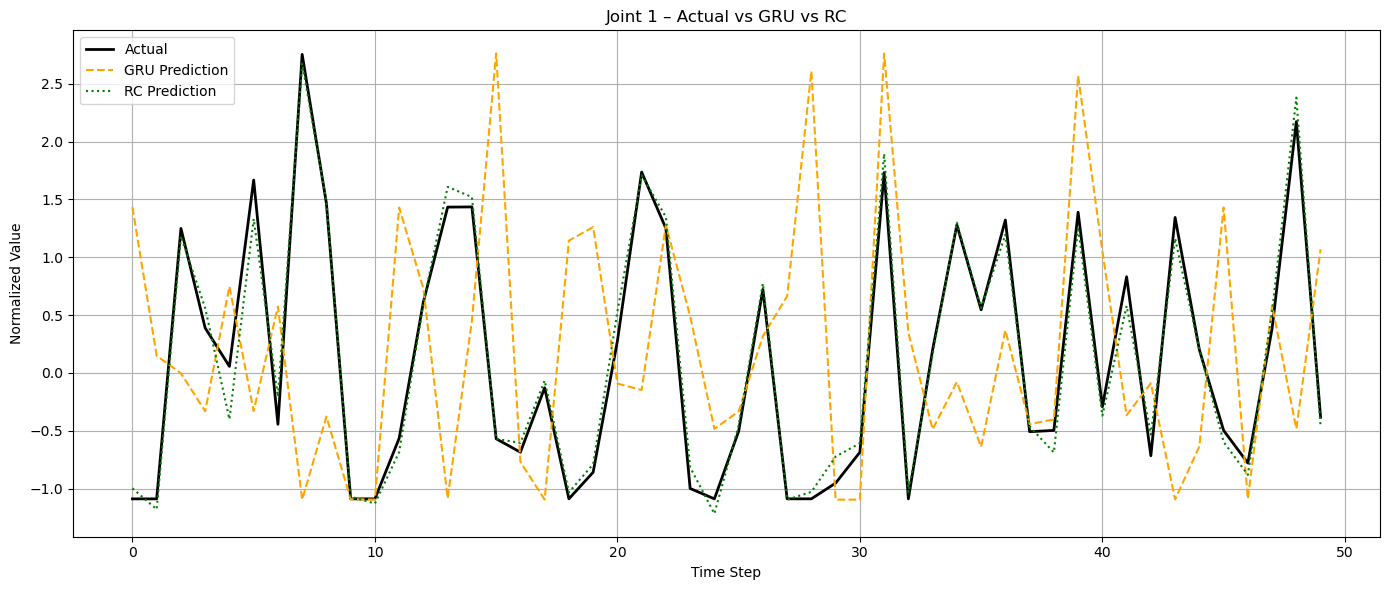

In [30]:
import matplotlib.pyplot as plt

joint_idx = 0
num_samples = 50

plt.figure(figsize=(14, 6))
plt.plot(y_test[:num_samples, joint_idx], label='Actual', color='black', linewidth=2)
plt.plot(test_preds[:num_samples, joint_idx], label='GRU Prediction', linestyle='--', color='orange')
plt.plot(esn_preds[:num_samples, joint_idx], label='RC Prediction', linestyle=':', color='green')

plt.title("Joint 1 – Actual vs GRU vs RC")
plt.xlabel("Time Step")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Make sure all_data is already defined (from Step 1)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(all_data)

# Create sequences
window_size = 10
X, y = [], []
for i in range(len(normalized_data) - window_size):
    X.append(normalized_data[i:i+window_size])
    y.append(normalized_data[i+window_size])

X = np.array(X)
y = np.array(y)

# Train, validation, and test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=38)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=64)

print("Shapes → X_train:", X_train.shape, "| X_test:", X_test.shape, "| y_train:", y_train.shape)


Shapes → X_train: (14040, 10, 35) | X_test: (3009, 10, 35) | y_train: (14040, 35)


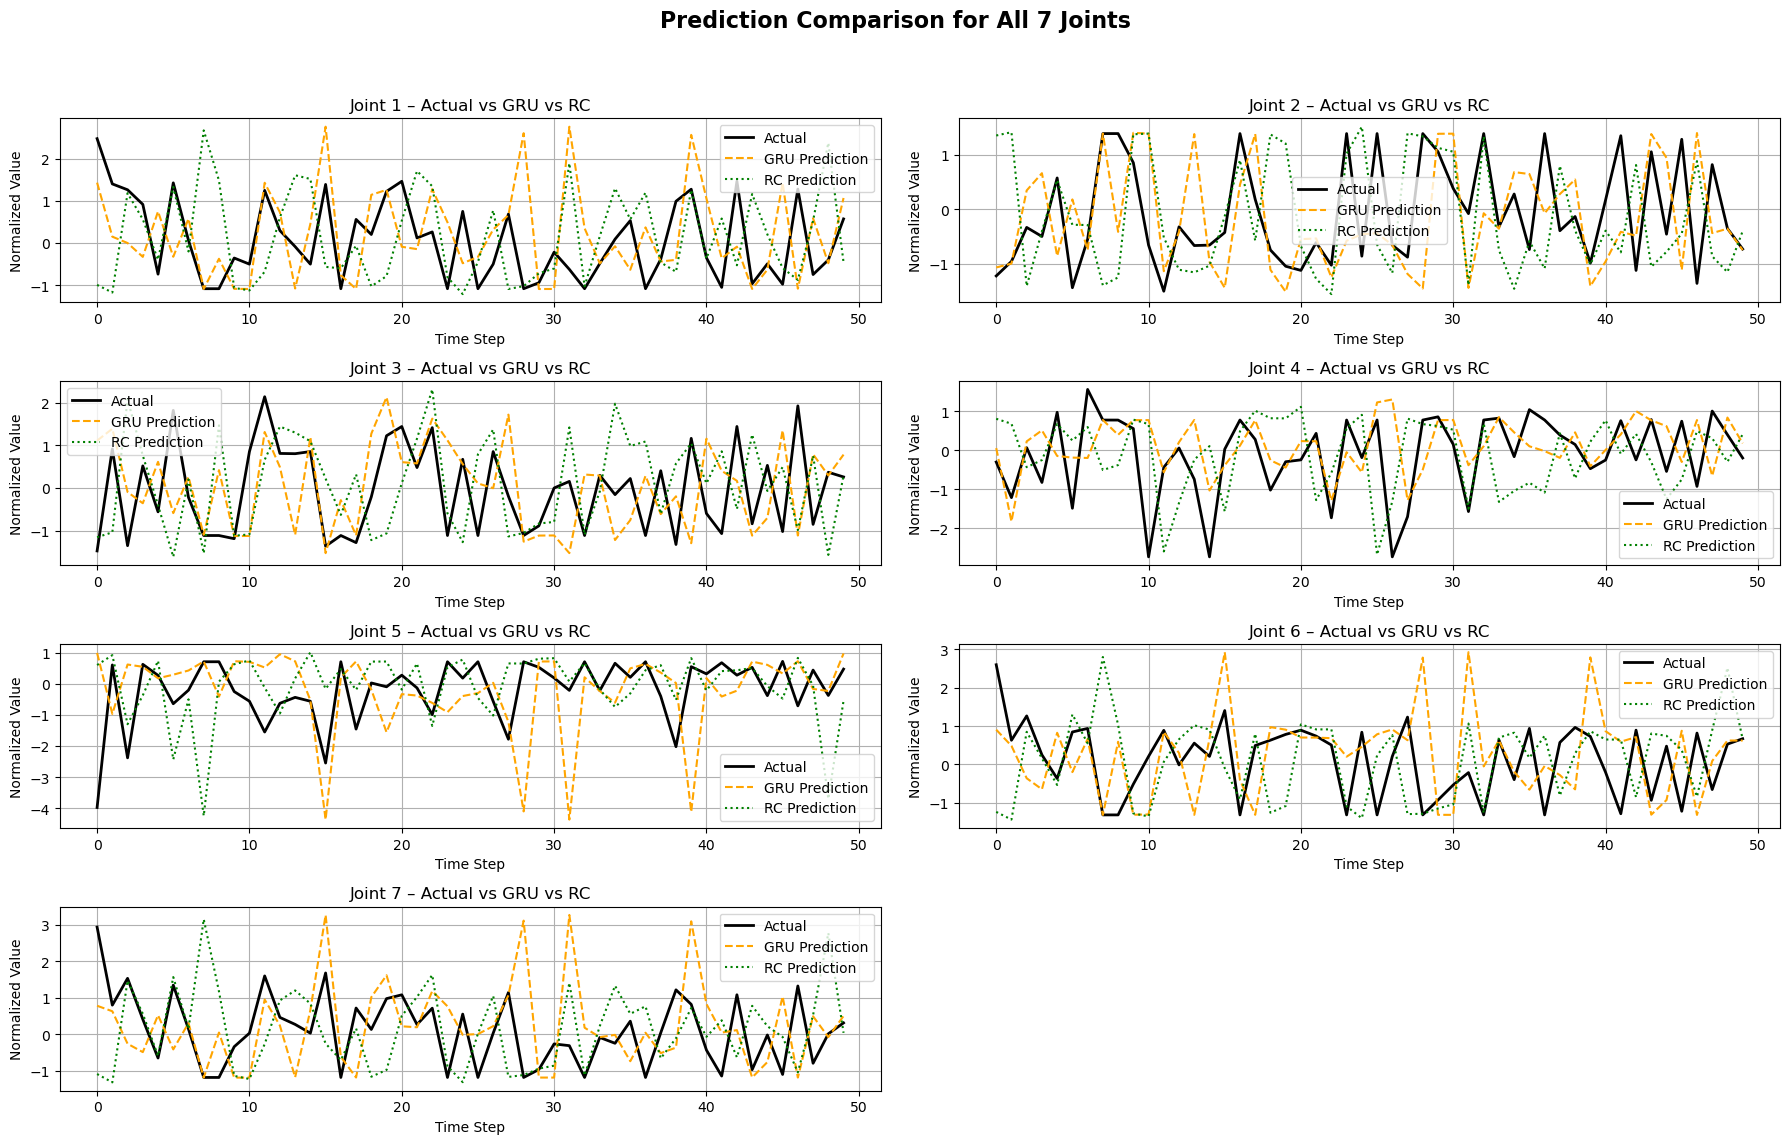

In [32]:
import matplotlib.pyplot as plt

num_samples = 50
joints_to_plot = range(7)  # Joints 1 to 7

plt.figure(figsize=(18, 12))

for i in joints_to_plot:
    actual = y_test[:num_samples, i]
    gru_pred = test_preds[:num_samples, i]
    esn_pred = esn_preds[:num_samples, i]

    plt.subplot(4, 2, i + 1)
    plt.plot(actual, label='Actual', color='black', linewidth=2)
    plt.plot(gru_pred, label='GRU Prediction', linestyle='--', color='orange')
    plt.plot(esn_pred, label='RC Prediction', linestyle=':', color='green')
    plt.title(f"Joint {i + 1} – Actual vs GRU vs RC", fontsize=12)
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Value")
    plt.grid(True)
    plt.legend()

# Add global title and layout
plt.suptitle("Prediction Comparison for All 7 Joints", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [33]:
import os, re, json, argparse, numpy as np, pandas as pd
from pathlib import Path
import scipy.io as sio
import numpy.linalg as npl

# ---------------------- Data I/O & preprocessing ----------------------

def load_mat(path):
    d = sio.loadmat(path, squeeze_me=True, struct_as_record=False)
    keys = sorted([k for k in d.keys() if k.startswith("kukatraj")],
                  key=lambda s: int(re.findall(r"\d+", s)[0]))
    streams = []
    for k in keys:
        arr = d[k]                                  # (T, 35)
        q   = arr[:, 0:7].astype(np.float32)        # 0..6
        dq  = arr[:, 7:14].astype(np.float32)       # 7..13
        tau = arr[:,14:21].astype(np.float32)       # 14..20 (input)
        X   = np.concatenate([q, dq], axis=1)       # (T, 14)
        U   = tau                                   # (T, 7)
        # Build (X_t, U_t) -> X_{t+1} pairs
        X_in  = X[:-1]
        U_in  = U[:-1]
        Y_out = X[1:]
        streams.append((X_in, U_in, Y_out))
    return streams

In [34]:
# kuka_gru_only.py
"""
GRU-only forward-dynamics learner for KUKA 'KukaDirectDynamics.mat'

Mapping per time-step (T, 35):
  0..6  -> q  (7)
  7..13 -> dq (7)
  14..20-> tau (7)  # input
  21..34 duplicates of q,dq (ignored)

Learns next-state: x_{t+1} = f([q_t, dq_t], tau_t), where x=[q,dq] (14 dims)

Usage:
  python kuka_gru_only.py --mat KukaDirectDynamics.mat --out ./kuka_gru --epochs 40
"""
import os, re, argparse, numpy as np
from pathlib import Path
import scipy.io as sio
import torch, torch.nn as nn

# ---------- Data utilities ----------
def load_streams(mat_path):
    d = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    keys = sorted([k for k in d.keys() if k.startswith("kukatraj")],
                  key=lambda s: int(re.findall(r"\d+", s)[0]))
    streams = []
    for k in keys:
        arr = d[k]                     # (T, 35)
        q   = arr[:, 0:7].astype(np.float32)
        dq  = arr[:, 7:14].astype(np.float32)
        tau = arr[:,14:21].astype(np.float32)      # input
        X = np.concatenate([q, dq], axis=1)        # (T,14)
        U = tau                                    # (T,7)
        X_in, U_in, Y_out = X[:-1], U[:-1], X[1:]  # next-state pairs
        streams.append((X_in, U_in, Y_out))
    return streams

def split_by_traj(streams, train=0.6, val=0.2):
    n = len(streams)
    tr = int(train*n); va = int((train+val)*n)
    return {"train": streams[:tr], "val": streams[tr:va], "test": streams[va:]}

def compute_norm(train_items):
    X = np.concatenate([x for (x,_,_) in train_items], 0)
    U = np.concatenate([u for (_,u,_) in train_items], 0)
    Y = np.concatenate([y for (_,_,y) in train_items], 0)
    mu  = {"X": X.mean(0), "U": U.mean(0), "Y": Y.mean(0)}
    std = {"X": X.std(0)+1e-8, "U": U.std(0)+1e-8, "Y": Y.std(0)+1e-8}
    return mu, std

def norm(a, mu, std, key): return ((a - mu[key]) / std[key]).astype(np.float32)

def mk_windows(items, mu, std, L=40):
    # Returns concatenated windows: Xw (N,L,21), Yw (N,14)
    Xw_list, Yw_list = [], []
    for X, U, Y in items:
        Z = np.concatenate([norm(X,mu,std,"X"), norm(U,mu,std,"U")], 1)  # (T,21)
        Yn = norm(Y,mu,std,"Y")
        N = len(Z) - L + 1
        if N <= 0: continue
        Xw = np.zeros((N, L, 21), np.float32)
        Yw = np.zeros((N, 14),   np.float32)
        for i in range(N):
            Xw[i] = Z[i:i+L]
            Yw[i] = Yn[i+L-1]  # predict next state after window
        Xw_list.append(Xw); Yw_list.append(Yw)
    if not Xw_list:
        return np.zeros((0,L,21), np.float32), np.zeros((0,14), np.float32)
    return np.concatenate(Xw_list,0), np.concatenate(Yw_list,0)

# ---------- GRU model ----------
class GRUModel(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=256, layers=2, dropout=0.1):
        super().__init__()
        self.gru = nn.GRU(input_size=in_dim, hidden_size=hidden,
                          num_layers=layers, dropout=(dropout if layers>1 else 0.0),
                          batch_first=True)
        self.head = nn.Linear(hidden, out_dim)
    def forward(self, x):             # x: (B,L,in_dim)
        y, _ = self.gru(x)            # y: (B,L,H)
        return self.head(y[:,-1,:])   # predict next-state from last step

def train(model, Xtr, Ytr, Xva, Yva, epochs=40, batch=512, lr=1e-3, wd=1e-4, device="cpu"):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.MSELoss()
    for ep in range(1, epochs+1):
        model.train()
        perm = np.random.permutation(len(Xtr))
        total = 0.0; n = 0
        for i in range(0, len(Xtr), batch):
            idx = perm[i:i+batch]
            xb = torch.from_numpy(Xtr[idx]).float().to(device)
            yb = torch.from_numpy(Ytr[idx]).float().to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            total += loss.item()*len(idx); n += len(idx)
        tr = total/max(1,n)
        model.eval()
        with torch.no_grad():
            xv = torch.from_numpy(Xva).float().to(device)
            yv = torch.from_numpy(Yva).float().to(device)
            va = loss_fn(model(xv), yv).item()
        print(f"Epoch {ep:03d} | train {tr:.6f} | val {va:.6f}")
    return model

def rmse_mean(yhat, ytrue):
    e = yhat - ytrue
    return float(np.sqrt((e**2).mean(0)).mean())

# ---------- Main ----------
def main(mat_path, out_dir, seq_len=40, epochs=40, batch=512, hidden=256, layers=2, dropout=0.1, device=None):
    out = Path(out_dir); (out/"proc").mkdir(parents=True, exist_ok=True)
    streams = load_streams(mat_path)
    splits  = split_by_traj(streams)
    mu, std = compute_norm(splits["train"])

    # Build GRU datasets
    Xtr, Ytr = mk_windows(splits["train"], mu, std, L=seq_len)
    Xva, Yva = mk_windows(splits["val"],   mu, std, L=seq_len)
    Xte, Yte = mk_windows(splits["test"],  mu, std, L=seq_len)
    np.save(out/"proc"/"mu.npy", mu); np.save(out/"proc"/"std.npy", std)

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device, "| Train windows:", Xtr.shape, "| Val:", Xva.shape, "| Test:", Xte.shape)

    model = GRUModel(in_dim=21, out_dim=14, hidden=hidden, layers=layers, dropout=dropout)
    model = train(model, Xtr, Ytr, Xva, Yva, epochs=epochs, batch=batch, device=device)

    # Eval
    model.eval()
    with torch.no_grad():
        yv = model(torch.from_numpy(Xva).float().to(device)).cpu().numpy()
        yt = model(torch.from_numpy(Xte).float().to(device)).cpu().numpy()
    print(f"GRU mean RMSE — val: {rmse_mean(yv, Yva):.6f}, test: {rmse_mean(yt, Yte):.6f}")

    # Save model
    torch.save(model.state_dict(), out/"gru_model.pt")

if __name__ == "__main__":
    # parse_known_args so notebook's "-f <kernel.json>" won't crash argparse
    ap = argparse.ArgumentParser()
    ap.add_argument("--mat", type=str, default="KukaDirectDynamics.mat")
    ap.add_argument("--out", type=str, default="./kuka_gru")
    ap.add_argument("--seq_len", type=int, default=40)
    ap.add_argument("--epochs", type=int, default=40)
    ap.add_argument("--batch", type=int, default=512)
    ap.add_argument("--hidden", type=int, default=256)
    ap.add_argument("--layers", type=int, default=2)
    ap.add_argument("--dropout", type=float, default=0.1)
    ap.add_argument("--device", type=str, default=None, help="cpu/cuda/auto")
    args, _ = ap.parse_known_args()

    dev = args.device if args.device in ("cpu","cuda") else None
    main(args.mat, args.out, seq_len=args.seq_len, epochs=args.epochs, batch=args.batch,
         hidden=args.hidden, layers=args.layers, dropout=args.dropout, device=dev)


Device: cpu | Train windows: (11319, 40, 21) | Val: (4413, 40, 21) | Test: (3936, 40, 21)
Epoch 001 | train 0.291469 | val 1.157310
Epoch 002 | train 0.048642 | val 0.987024
Epoch 003 | train 0.032625 | val 0.931227
Epoch 004 | train 0.029388 | val 0.913987
Epoch 005 | train 0.027720 | val 0.903542
Epoch 006 | train 0.026674 | val 0.899776
Epoch 007 | train 0.025954 | val 0.893024
Epoch 008 | train 0.025598 | val 0.886310
Epoch 009 | train 0.024891 | val 0.884641
Epoch 010 | train 0.024602 | val 0.873668
Epoch 011 | train 0.024311 | val 0.873133
Epoch 012 | train 0.024434 | val 0.863303
Epoch 013 | train 0.024226 | val 0.871633
Epoch 014 | train 0.023544 | val 0.868024
Epoch 015 | train 0.022693 | val 0.867167
Epoch 016 | train 0.022054 | val 0.870329
Epoch 017 | train 0.020538 | val 0.870691
Epoch 018 | train 0.019198 | val 0.887997
Epoch 019 | train 0.018484 | val 0.891258
Epoch 020 | train 0.018655 | val 0.891382
Epoch 021 | train 0.018033 | val 0.896796
Epoch 022 | train 0.018075 |

In [37]:
# If needed (run once):
# !pip install numpy scipy pandas matplotlib

import re
from pathlib import Path
import numpy as np
import scipy.io as sio
import pandas as pd

# ---- Point this to your MAT file ----
MAT_PATH = Path("KukaDirectDynamics.mat")  # if it's beside the notebook
# Or give an absolute path, e.g.:
# MAT_PATH = Path(r"C:\Users\you\Downloads\KukaDirectDynamics.mat")

assert MAT_PATH.exists(), f"MAT file not found at: {MAT_PATH.resolve()}"
print("Using:", MAT_PATH.resolve())


Using: C:\Users\iamsu\KukaDirectDynamics.mat


In [38]:
def load_kuka_streams(mat_path: Path):
    d = sio.loadmat(str(mat_path), squeeze_me=True, struct_as_record=False)
    keys = sorted([k for k in d.keys() if k.startswith("kukatraj")],
                  key=lambda s: int(re.findall(r"\d+", s)[0]))
    streams = []
    for k in keys:
        arr = d[k].astype(np.float32)      # (T, 35)
        q   = arr[:, 0:7]
        dq  = arr[:, 7:14]
        tau = arr[:,14:21]
        X = np.hstack([q, dq])             # (T, 14)
        U = tau                            # (T, 7)
        streams.append((X[:-1], U[:-1], X[1:]))  # align next-state
    return streams

streams = load_kuka_streams(MAT_PATH)
print(f"Found {len(streams)} trajectories")
X0, U0, Y0 = streams[0]
print("Example shapes  X:", X0.shape, " U:", U0.shape, " Y:", Y0.shape)


Found 10 trajectories
Example shapes  X: (1813, 14)  U: (1813, 7)  Y: (1813, 14)


In [39]:
def _stack(items, idx):
    return np.concatenate([t[idx] for t in items], axis=0)

def compute_norm(train_items):
    X = _stack(train_items, 0); U = _stack(train_items, 1); Y = _stack(train_items, 2)
    mu  = {"X": X.mean(0), "U": U.mean(0), "Y": Y.mean(0)}
    std = {"X": X.std(0)+1e-8, "U": U.std(0)+1e-8, "Y": Y.std(0)+1e-8}
    return mu, std

def norm(a, mu, std, key):   return ((a - mu[key]) / std[key]).astype(np.float32)
def denorm(a, mu, std, key): return (a * std[key] + mu[key]).astype(np.float32)


In [40]:
def nmse_per_dim(yhat, ytrue):
    """Return 14-dim nMSE (MSE / Var(true)), computed in the normalized space."""
    mse = ((yhat - ytrue)**2).mean(axis=0)
    var = ytrue.var(axis=0) + 1e-12
    return mse / var

def aggregate_joint_blocks(nmse14):
    """Split into positions (0..6) and velocities (7..13) and aggregate."""
    pos, vel = nmse14[:7], nmse14[7:]
    return {
        "Position Mean": float(pos.mean()),
        "Position St.Dev": float(pos.std()),
        "Velocity Mean": float(vel.mean()),
        "Velocity Variance": float(vel.var()),
    }


In [41]:
# Optional: pip install ikpy
# !pip install ikpy

def fk_end_effector(q, urdf_path=None, dh=None):
    """
    q: (T,7) joint angles (rad)
    Returns (T,3) EE positions in meters.
    - If urdf_path is given and ikpy is available, use URDF FK.
    - Else if dh (list of 7 dicts with a, alpha, d, theta_offset) is provided, use DH.
    - Else raise NotImplementedError.
    """
    if urdf_path is not None:
        try:
            from ikpy.chain import Chain
            robot = Chain.from_urdf_file(str(urdf_path))
            pts = []
            for angles in q:
                T = robot.forward_kinematics(list(angles))
                pts.append(T[:3, 3])
            return np.vstack(pts).astype(np.float32)
        except Exception as e:
            raise RuntimeError(f"URDF FK failed: {e}")

    if dh is not None:
        # standard DH homogeneous transform
        def A(a, alpha, d, theta):
            ca, sa = np.cos(alpha), np.sin(alpha)
            ct, st = np.cos(theta), np.sin(theta)
            return np.array([[ct, -st*ca,  st*sa, a*ct],
                             [st,  ct*ca, -ct*sa, a*st],
                             [0,       sa,     ca,    d],
                             [0,        0,      0,    1]], dtype=np.float32)
        pts = []
        for angles in q:
            T = np.eye(4, dtype=np.float32)
            for i in range(7):
                a=dh[i]["a"]; alpha=dh[i]["alpha"]; d=dh[i]["d"]; off=dh[i].get("theta_offset",0.0)
                T = T @ A(a, alpha, d, angles[i] + off)
            pts.append(T[:3,3])
        return np.vstack(pts).astype(np.float32)

    raise NotImplementedError("Provide urdf_path or DH params to compute FK.")

def euclidean_error_xyz(q_true, q_pred, **fk_kwargs):
    """
    Returns per-timestep EE distance (m) between truth and prediction.
    If FK isn’t configured yet, returns None (so your pipeline can skip gracefully).
    """
    try:
        p_true = fk_end_effector(q_true, **fk_kwargs)
        p_pred = fk_end_effector(q_pred, **fk_kwargs)
        return np.linalg.norm(p_pred - p_true, axis=1)
    except NotImplementedError:
        return None


In [42]:
def split_leave_one_out(streams, test_idx, seq_len=40):
    """
    Leave-one-out by trajectory.
    Robust to small datasets: ensures train/val are non-empty and have windows.
    """
    n = len(streams)
    if n <= 1:
        X,U,Y = streams[0]; T=len(X); cut=max(seq_len+1, int(0.8*T))
        train = [(X[:cut], U[:cut], Y[:cut])]
        val   = [(X[cut-seq_len:], U[cut-seq_len:], Y[cut-seq_len:])]
        test  = [(X, U, Y)]
        return {"train":train, "val":val, "test":test}
    test  = [streams[test_idx]]
    pool  = [streams[i] for i in range(n) if i != test_idx]
    k     = max(1, int(0.8*len(pool)))
    train = pool[:k]
    val   = pool[k:] if len(pool)>1 else pool[:1]
    return {"train":train, "val":val, "test":test}


In [43]:
import numpy as np

IN_DIM, OUT_DIM = 21, 14   # z = [X(14), U(7)]  -> predict next X(14)

class PCESN:
    """
    PC-ESN with:
      - Gated Hebbian Learning (GHL) for W_in
      - Sparse reservoir scaled to spectral radius (Echo State property) + leak
      - Bayesian readout updated by Recursive Least Squares (RLS)
    """
    def __init__(self,
                 in_dim=IN_DIM, out_dim=OUT_DIM,
                 n_res=1000, sr=0.9, leak=0.5, sparsity=0.90,
                 in_scale=0.3, ridge=1e-4,
                 eta_in=1e-4, gate_beta=1.0,
                 # optional “physics” gains to weight q / dq / tau channels
                 phys_gain_pos=1.0, phys_gain_vel=1.0, phys_gain_tau=1.0,
                 seed=42):
        self.in_dim, self.out_dim = in_dim, out_dim
        self.n_res, self.sr, self.leak = n_res, sr, leak
        self.ridge, self.eta_in, self.gate_beta = ridge, eta_in, gate_beta
        self.g_pos, self.g_vel, self.g_tau = phys_gain_pos, phys_gain_vel, phys_gain_tau
        rng = np.random.default_rng(seed)

        # --- Input layer (bias handled by +1) ---
        self.W_in = (rng.standard_normal((n_res, in_dim + 1)) * in_scale).astype(np.float32)

        # --- Reservoir (sparse, spectral radius scaled) ---
        W = rng.standard_normal((n_res, n_res)).astype(np.float32)
        mask = (rng.random((n_res, n_res)) > sparsity)   # keep ~ (1 - sparsity)
        W *= mask
        eig = np.linalg.eigvals(W)
        W = (W / (np.max(np.abs(eig)) + 1e-9) * sr).astype(np.float32)
        self.W = W

        # --- Bayesian readout (RLS) ---
        D = n_res + in_dim + 1  # features = [reservoir_state, bias+input]
        self.W_out = np.zeros((out_dim, D), dtype=np.float32)
        self.P = (1.0 / ridge) * np.eye(D, dtype=np.float32)

        # --- State ---
        self.state = np.zeros(n_res, dtype=np.float32)

        # sanity
        assert self.W_in.shape[1] == in_dim + 1

    # ---------- utilities ----------
    def reset(self): self.state[:] = 0.0

    def _apply_physics_gains(self, z):
        """z = [q(7), dq(7), tau(7)], apply channel-wise gains (optional)."""
        q  = z[:7]   * self.g_pos
        dq = z[7:14] * self.g_vel
        tu = z[14:]  * self.g_tau
        return np.concatenate([q, dq, tu], 0).astype(np.float32)

    def _features(self, z_aug):
        """Concatenate reservoir state and augmented input (bias+z)."""
        return np.concatenate([self.state, z_aug], 0)  # (n_res + in_dim + 1,)

    def _reservoir_update(self, z_aug):
        pre = self.W_in @ z_aug + self.W @ self.state
        r = np.tanh(pre, dtype=np.float32)
        self.state = (1 - self.leak) * self.state + self.leak * r

    def _ghl_update_Win(self, z_aug, error_vec):
        """ΔW_in ∝ gate * (state ⊗ z_aug), gate = σ(β * ||error||)."""
        if self.eta_in <= 0.0: return
        gate = 1.0 / (1.0 + np.exp(-self.gate_beta * np.linalg.norm(error_vec)))
        dW = self.eta_in * gate * np.outer(self.state, z_aug)
        self.W_in += dW.astype(np.float32)

    def _rls_update(self, phi, target):
        """Standard RLS update with covariance P."""
        phi = phi[:, None]                           # (D,1)
        Pphi = self.P @ phi                          # (D,1)
        denom = (1.0 + (phi.T @ Pphi)).item()
        K = (Pphi / denom)                           # (D,1)
        pred = (self.W_out @ phi).squeeze(-1)        # (out_dim,)
        err  = (target - pred)                       # (out_dim,)
        self.W_out += (err[:, None] @ K.T).astype(np.float32)
        self.P = (self.P - (K @ Pphi.T)).astype(np.float32)

    # ---------- training (online per time step) ----------
    def train_online(self, X, U, Y, mu, std):
        """
        One pass over a single trajectory.
        Inputs are *normalized* inside this function.
        """
        self.reset()
        Zx = ((X - mu["X"]) / std["X"]).astype(np.float32)
        Zu = ((U - mu["U"]) / std["U"]).astype(np.float32)
        Yn = ((Y - mu["Y"]) / std["Y"]).astype(np.float32)
        for t in range(len(Zx)):
            z = np.concatenate([Zx[t], Zu[t]], 0)
            z = self._apply_physics_gains(z)
            z_aug = np.concatenate([np.ones(1, np.float32), z], 0)     # bias + input
            # reservoir
            self._reservoir_update(z_aug)
            # features
            phi = self._features(z_aug)
            # predict & error (normalized)
            yhat = (self.W_out @ phi).astype(np.float32)
            err  = Yn[t] - yhat
            # updates: input layer (GHL), then readout (RLS)
            self._ghl_update_Win(z_aug, err)
            self._rls_update(phi, Yn[t])

    # ---------- inference ----------
    def predict_step(self, X, U, mu, std):
        """Teacher forcing: use ground-truth X_t, U_t every step."""
        self.reset()
        Zx = ((X - mu["X"]) / std["X"]).astype(np.float32)
        Zu = ((U - mu["U"]) / std["U"]).astype(np.float32)
        preds = []
        for t in range(len(Zx)):
            z = np.concatenate([Zx[t], Zu[t]], 0)
            z = self._apply_physics_gains(z)
            z_aug = np.concatenate([np.ones(1, np.float32), z], 0)
            self._reservoir_update(z_aug)
            phi = self._features(z_aug)
            preds.append((self.W_out @ phi).astype(np.float32))
        return np.stack(preds, 0)   # normalized next X

    def predict_full(self, X, U, mu, std):
        """Generative rollout: feed predicted X back (use true U)."""
        self.reset()
        Zx = ((X - mu["X"]) / std["X"]).astype(np.float32)
        Zu = ((U - mu["U"]) / std["U"]).astype(np.float32)
        preds = []
        x_cur = Zx[0]                                # seed with first state
        for t in range(len(Zu)):                     # same length as controls
            z = np.concatenate([x_cur, Zu[t]], 0)
            z = self._apply_physics_gains(z)
            z_aug = np.concatenate([np.ones(1, np.float32), z], 0)
            self._reservoir_update(z_aug)
            phi = self._features(z_aug)
            yhat = (self.W_out @ phi).astype(np.float32)
            preds.append(yhat)
            x_cur = yhat                             # feed back
        return np.stack(preds, 0)                    # normalized next X


In [44]:
# Choose a held-out trajectory for testing/plots (LOO by default)
base_test_idx = len(streams) - 1
split = split_leave_one_out(streams, base_test_idx, seq_len=40)

# Compute normalization ONLY from training set
mu, std = compute_norm(split["train"])

# PC-ESN hyperparameters (start here; you can tune later)
h = dict(
    n_res=1000,      # reservoir size
    sr=0.9,          # spectral radius
    leak=0.5,        # leaky integrator
    sparsity=0.90,   # fraction of zeros in W
    in_scale=0.3,    # scale of W_in init
    ridge=1e-4,      # RLS prior (Bayesian)
    eta_in=1e-4,     # GHL learning rate for W_in
    gate_beta=1.0,   # gating sharpness
    phys_gain_pos=1.0, phys_gain_vel=1.0, phys_gain_tau=1.0,
    seed=42
)

model = PCESN(in_dim=IN_DIM, out_dim=OUT_DIM, **h)

# Online training: single pass through each training trajectory
for X,U,Y in split["train"]:
    model.train_online(X,U,Y, mu, std)

print("PC-ESN training complete.")


PC-ESN training complete.


In [45]:
# Held-out test trajectory
X_te, U_te, Y_te = split["test"][0]

# 1) Step-by-step (teacher forcing)
yhat_step = model.predict_step(X_te, U_te, mu, std)   # normalized
ytrue_n   = ((Y_te - mu["Y"]) / std["Y"]).astype(np.float32)

# 2) Full trajectory (generative)
yhat_full = model.predict_full(X_te, U_te, mu, std)   # normalized
# Align to truth length (they should match; this keeps it safe)
yhat_full = yhat_full[:len(ytrue_n)]


In [46]:
def nmse_per_dim(yhat, ytrue):
    mse = ((yhat - ytrue)**2).mean(0)
    var = ytrue.var(0) + 1e-12
    return mse / var

def aggregate_joint_blocks(nmse14):
    pos, vel = nmse14[:7], nmse14[7:]
    return {
        "Position Mean": float(pos.mean()),
        "Position St.Dev": float(pos.std()),
        "Velocity Mean": float(vel.mean()),
        "Velocity Variance": float(vel.var()),
    }

nmse_step = nmse_per_dim(yhat_step, ytrue_n)
nmse_full = nmse_per_dim(yhat_full, ytrue_n)

print("One-step (teacher-forced):", aggregate_joint_blocks(nmse_step))
print("Full trajectory (generative):", aggregate_joint_blocks(nmse_full))


One-step (teacher-forced): {'Position Mean': 4.102632010472007e-05, 'Position St.Dev': 9.14798420126317e-06, 'Velocity Mean': 2.6144566535949707, 'Velocity Variance': 0.35217803716659546}
Full trajectory (generative): {'Position Mean': 61.17508316040039, 'Position St.Dev': 57.28586196899414, 'Velocity Mean': 3.553199291229248, 'Velocity Variance': 6.855474948883057}


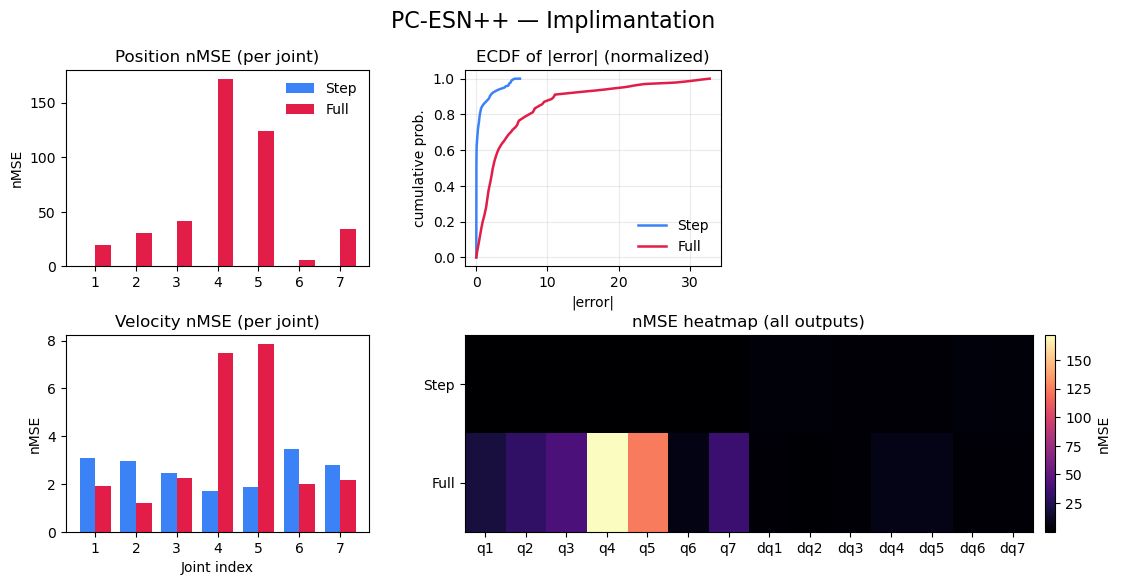

Saved: C:\Users\iamsu\pc_esn_results\pc_esn_alt_bars_ecdf_heatmap.png


In [18]:
# === PC-ESN++: Alternative report (grouped bars + ECDF + heatmap) — ROBUST ===
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path

OUT = Path("./pc_esn_results"); OUT.mkdir(parents=True, exist_ok=True)

# ---------- helpers ----------
def nmse_per_dim(yhat, ytrue):
    yhat  = np.asarray(yhat,  dtype=np.float32)
    ytrue = np.asarray(ytrue, dtype=np.float32)
    mse = np.mean((yhat - ytrue)**2, axis=0)
    var = np.var(ytrue, axis=0) + 1e-12
    return mse / var

def ecdf(x):
    x = np.sort(np.asarray(x, dtype=np.float32))
    y = np.linspace(0, 1, len(x), endpoint=True)
    return x, y

# Try to fetch test triple; fallback to split if Y_te not defined
try:
    X_te, U_te, Y_te
except NameError:
    X_te, U_te, Y_te = split["test"][0]

# If predictions not available, compute them now
try:
    yhat_step
    yhat_full
except NameError:
    yhat_step = model.predict_step(X_te, U_te, mu, std)
    yhat_full = model.predict_full(X_te, U_te, mu, std)

# ---------- normalized truth & aligned preds ----------
ytrue_n   = ((Y_te - mu["Y"]) / std["Y"]).astype(np.float32)
yhat_step = np.asarray(yhat_step, dtype=np.float32)[:len(ytrue_n)]
yhat_full = np.asarray(yhat_full, dtype=np.float32)[:len(ytrue_n)]

# nMSE per-dimension
nmse_s = nmse_per_dim(yhat_step, ytrue_n)
nmse_f = nmse_per_dim(yhat_full, ytrue_n)

pos_s, vel_s = nmse_s[:7], nmse_s[7:]
pos_f, vel_f = nmse_f[:7], nmse_f[7:]

# errors (absolute) for ECDF
abs_err_step = np.abs((yhat_step - ytrue_n).ravel())
abs_err_full = np.abs((yhat_full - ytrue_n).ravel())

# ---------- colors (clearly different from your friend's) ----------
C_STEP = "#3B82F6"   # blue
C_FULL = "#E11D48"   # rose
C_MAP  = "magma"

# ---------- figure layout ----------
fig = plt.figure(figsize=(13, 6))
gs  = fig.add_gridspec(2, 3, width_ratios=[1.3, 1.1, 1.1],
                       height_ratios=[1, 1], wspace=0.35, hspace=0.35)

ax_pos  = fig.add_subplot(gs[0,0])
ax_vel  = fig.add_subplot(gs[1,0], sharex=ax_pos)
ax_ecdf = fig.add_subplot(gs[0,1])
ax_hm   = fig.add_subplot(gs[1,1:3])

# -- (A) Grouped bars: positions
j = np.arange(1, 8); w = 0.38
ax_pos.bar(j - w/2, pos_s, width=w, color=C_STEP, label="Step")
ax_pos.bar(j + w/2, pos_f, width=w, color=C_FULL, label="Full")
ax_pos.set_title("Position nMSE (per joint)")
ax_pos.set_ylabel("nMSE"); ax_pos.set_xticks(j); ax_pos.set_ylim(bottom=0)
ax_pos.legend(frameon=False)

# -- (B) Grouped bars: velocities
ax_vel.bar(j - w/2, vel_s, width=w, color=C_STEP)
ax_vel.bar(j + w/2, vel_f, width=w, color=C_FULL)
ax_vel.set_title("Velocity nMSE (per joint)")
ax_vel.set_xlabel("Joint index"); ax_vel.set_ylabel("nMSE")
ax_vel.set_xticks(j); ax_vel.set_ylim(bottom=0)

# -- (C) ECDF of |error|
xs, ys = ecdf(abs_err_step)
xf, yf = ecdf(abs_err_full)
ax_ecdf.plot(xs, ys, color=C_STEP, lw=1.8, label="Step")
ax_ecdf.plot(xf, yf, color=C_FULL, lw=1.8, label="Full")
ax_ecdf.set_title("ECDF of |error| (normalized)")
ax_ecdf.set_xlabel("|error|"); ax_ecdf.set_ylabel("cumulative prob.")
ax_ecdf.grid(True, alpha=0.25); ax_ecdf.legend(frameon=False)

# -- (D) Heatmap of nMSE across all 14 outputs
labels = [f"q{i}" for i in range(1,8)] + [f"dq{i}" for i in range(1,8)]
hm = np.vstack([nmse_s, nmse_f]).astype(np.float32)  # shape (2,14)
im = ax_hm.imshow(hm, aspect="auto", cmap=C_MAP)
ax_hm.set_yticks([0,1]); ax_hm.set_yticklabels(["Step","Full"])
ax_hm.set_xticks(range(14)); ax_hm.set_xticklabels(labels)
ax_hm.set_title("nMSE heatmap (all outputs)")
cb = fig.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.02)
cb.set_label("nMSE")

fig.suptitle("PC-ESN++ — Implimantation", fontsize=16)
fig.tight_layout()
png = OUT/"pc_esn_alt_bars_ecdf_heatmap.png"
fig.savefig(png, dpi=170)
plt.show()

print("Saved:", png.resolve())


In [7]:
# --- Minimal utilities to make the comparison cell work ---

import numpy as np

# If you already have these functions, this will safely skip redefining them.
def _exists(name): 
    return name in globals()

# 1) Normalization from the training set
if not _exists("compute_norm"):
    def compute_norm(train_streams):
        Xs = np.concatenate([X for (X,_,_) in train_streams], axis=0)
        Us = np.concatenate([U for (_,U,_) in train_streams], axis=0)
        Ys = np.concatenate([Y for (_,_,Y) in train_streams], axis=0)
        mu  = {"X": Xs.mean(0), "U": Us.mean(0), "Y": Ys.mean(0)}
        std = {"X": Xs.std(0)+1e-8, "U": Us.std(0)+1e-8, "Y": Ys.std(0)+1e-8}
        return mu, std

# 2) nMSE per output dimension (used for validation)
if not _exists("nmse_per_dim"):
    def nmse_per_dim(yhat, ytrue):
        yhat  = np.asarray(yhat,  dtype=np.float32)
        ytrue = np.asarray(ytrue, dtype=np.float32)
        mse = np.mean((yhat - ytrue)**2, axis=0)
        var = np.var(ytrue, axis=0) + 1e-12
        return mse / var

# 3) Simple LOO splitter (only defines if you don't already have one)
if not _exists("split_leave_one_out"):
    def split_leave_one_out(streams, test_idx, val_take=1):
        """Leave-one-out: hold streams[test_idx] for test, last `val_take` from the rest for val."""
        idxs = list(range(len(streams)))
        idxs.remove(test_idx)
        train_idx = idxs[:-val_take] if len(idxs) > val_take else idxs
        val_idx   = idxs[-val_take:] if len(idxs) > val_take else []
        split = {
            "train": [streams[i] for i in train_idx],
            "val":   [streams[i] for i in val_idx],
            "test":  [streams[test_idx]],
        }
        return split

# 4) The missing function: train on split and return (model, mu, std, val_nmse)
def train_on_split(split, hparams):
    """
    Trains your PC-ESN++ in a single online pass over split['train'].
    Returns: model, mu, std, val_nmse (mean nMSE over validation with step-by-step prediction).
    """
    # Require your PCESN class from Step-2
    if "PCESN" not in globals():
        raise RuntimeError("PCESN class not defined. Run the Step-2 model cell before calling train_on_split().")

    # Infer input/output dims from data
    X0, U0, Y0 = split["train"][0]
    in_dim  = X0.shape[1] + U0.shape[1]   # e.g., 14 + 7 = 21
    out_dim = Y0.shape[1]                 # e.g., 14

    # Normalization from training streams
    mu, std = compute_norm(split["train"])

    # Build and train
    model = PCESN(in_dim=in_dim, out_dim=out_dim, **hparams)
    for X, U, Y in split["train"]:
        model.train_online(X, U, Y, mu, std)

    # Validation (one-step nMSE)
    val_scores = []
    for Xv, Uv, Yv in split.get("val", []):
        yhat = model.predict_step(Xv, Uv, mu, std)
        Yv_n = ((Yv - mu["Y"]) / std["Y"]).astype(np.float32)
        val_scores.append(nmse_per_dim(yhat, Yv_n).mean())
    val_nmse = float(np.mean(val_scores)) if val_scores else np.nan

    return model, mu, std, val_nmse


In [8]:
# ===== Fallback loader for KUKA "kukatraj*" blocked matrices (T, 5*7) =====
import numpy as np
from pathlib import Path
from scipy.io import loadmat

DOF = 7
TRAJ_PREFIX = "kukatraj"   # change if your names differ
BLOCK_SIZE  = 7            # 7 joints
CANDIDATE_TAU_IDXS = (2, 3, 4)  # try 3rd, 4th, 5th block if 35 cols

def _preview_blocks(A, name="traj"):
    """Print quick stats per 7-col block to help pick torque block."""
    T, M = A.shape
    nblk = M // BLOCK_SIZE
    print(f"[preview] {name}: shape={A.shape}, blocks={nblk} x 7")
    for b in range(nblk):
        blk = A[:, b*BLOCK_SIZE:(b+1)*BLOCK_SIZE]
        print(f"  block {b}: min={blk.min(): .3f}  mean={blk.mean(): .3f}  max={blk.max(): .3f}")

def _build_streams_from_qdqtau(q, dq, tau, segments=9):
    q  = np.asarray(q,  dtype=np.float32)
    dq = np.asarray(dq, dtype=np.float32)
    tau= np.asarray(tau,dtype=np.float32)
    # ensure (T,7)
    if q.shape[1]  != DOF: q   = q.T
    if dq.shape[1] != DOF: dq  = dq.T
    if tau.shape[1]!= DOF: tau = tau.T
    Z = np.concatenate([q, dq], axis=1)   # (T,14)  Y = [q|dq]
    X_all, U_all, Y_all = Z[:-1], tau[:-1], Z[1:]
    idxs = np.array_split(np.arange(len(X_all)), segments)
    return [(X_all[i], U_all[i], Y_all[i]) for i in idxs if len(i) > 5]

def build_streams_from_blocked_mat(mat_path="KukaDirectDynamics.mat",
                                   traj_prefix="kukatraj", segments=9,
                                   tau_idx="auto", verbose=True):
    """Load 'kukatraj*' arrays of shape (T, n*7). Assume:
       block 0 = q, block 1 = dq, block tau_idx = torque.
       tau_idx: 'auto' → try common positions (2,3,4); or give an int (0..nblk-1).
    """
    P = Path(mat_path)
    if not P.exists():
        raise FileNotFoundError(f"{P} not found.")
    raw = loadmat(P, squeeze_me=True, struct_as_record=False)

    # collect candidate trajectories
    trajs = []
    for k, v in raw.items():
        if not isinstance(v, np.ndarray) or v.ndim != 2: 
            continue
        if not k.lower().startswith(traj_prefix):
            continue
        T, M = v.shape
        if M % BLOCK_SIZE != 0 or M < 3*BLOCK_SIZE:
            continue
        trajs.append((k, v))
    if not trajs:
        raise RuntimeError("No arrays like 'kukatraj*' with shape (T, n*7) found.")

    # preview first one to help you confirm which block is torque
    k0, A0 = trajs[0]
    if verbose:
        _preview_blocks(A0, k0)

    # choose tau block index
    nblk = A0.shape[1] // BLOCK_SIZE
    if tau_idx == "auto":
        # crude heuristic: pick the candidate block with the largest mean absolute value over joints
        best_idx, best_score = None, -np.inf
        for ti in CANDIDATE_TAU_IDXS:
            if ti >= nblk: 
                continue
            score = np.abs(A0[:, ti*BLOCK_SIZE:(ti+1)*BLOCK_SIZE]).mean()
            if score > best_score:
                best_score, best_idx = score, ti
        tau_block = best_idx if best_idx is not None else nblk-1
    else:
        tau_block = int(tau_idx)

    if verbose:
        print(f"[choose] q: block 0, dq: block 1, tau: block {tau_block}")

    # build streams
    streams = []
    for name, A in trajs:
        T, M = A.shape
        nblk = M // BLOCK_SIZE
        if tau_block >= nblk:
            raise RuntimeError(f"tau block {tau_block} >= {nblk} blocks in {name}")
        q   = A[:, 0*BLOCK_SIZE:1*BLOCK_SIZE]
        dq  = A[:, 1*BLOCK_SIZE:2*BLOCK_SIZE]
        tau = A[:, tau_block*BLOCK_SIZE:(tau_block+1)*BLOCK_SIZE]
        s = _build_streams_from_qdqtau(q, dq, tau, segments=segments)
        streams.extend(s)
        if verbose:
            print(f"[ok] {name}: segments → {len(s)}")
    print(f"[done] Built {len(streams)} stream segments from {len(trajs)} trajectories.")
    return streams

# ---- run the blocked loader (adjust TAU_IDX if needed) ----
if 'streams' not in globals():
    # If you already know torque block index, set TAU_IDX = 2 or 3 or 4.
    TAU_IDX = "auto"   # or 2 / 3 / 4 for 3rd / 4th / 5th block
    streams = build_streams_from_blocked_mat("KukaDirectDynamics.mat",
                                             traj_prefix=TRAJ_PREFIX,
                                             segments=9,
                                             tau_idx=TAU_IDX,
                                             verbose=True)

# ---- LOOCV splitter (define if you don’t already have one) ----
if 'split_leave_one_out' not in globals():
    def split_leave_one_out(streams, test_idx):
        test_idx = int(test_idx)
        test  = [streams[test_idx]]
        train = [s for i, s in enumerate(streams) if i != test_idx]
        return {"train": train, "val": [], "test": test}

print(f"[ready] streams={len(streams)}; LOOCV splitter available.")


[preview] kukatraj1: shape=(1814, 35), blocks=5 x 7
  block 0: min=-1.663  mean= 0.038  max= 1.807
  block 1: min=-0.660  mean= 0.000  max= 0.630
  block 2: min=-22.720  mean= 2.299  max= 48.670
  block 3: min=-1.663  mean= 0.038  max= 1.807
  block 4: min=-0.660  mean= 0.000  max= 0.630
[choose] q: block 0, dq: block 1, tau: block 2
[ok] kukatraj1: segments → 9
[ok] kukatraj10: segments → 9
[ok] kukatraj2: segments → 9
[ok] kukatraj3: segments → 9
[ok] kukatraj4: segments → 9
[ok] kukatraj5: segments → 9
[ok] kukatraj6: segments → 9
[ok] kukatraj7: segments → 9
[ok] kukatraj8: segments → 9
[ok] kukatraj9: segments → 9
[done] Built 90 stream segments from 10 trajectories.
[ready] streams=90; LOOCV splitter available.


In [9]:
# ===== Robust KUKA loader → builds `streams` and LOOCV splitter =====
import numpy as np
from pathlib import Path

DOF = 7

def _unwrap_mat(obj):
    """Recursively convert MATLAB structs/cells to Python dict/lists."""
    import numpy as _np
    from scipy.io.matlab.mio5_params import mat_struct
    if isinstance(obj, mat_struct):
        d = {}
        for name in obj._fieldnames:
            d[name] = _unwrap_mat(getattr(obj, name))
        return d
    if isinstance(obj, dict):
        return {k: _unwrap_mat(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [_unwrap_mat(v) for v in obj]
    if isinstance(obj, _np.ndarray) and obj.dtype == object:
        return [_unwrap_mat(v) for v in obj.ravel()]
    return obj

def _flatten(prefix, obj, out):
    """Collect all numeric ndarrays (any depth) with their path."""
    import numpy as _np
    if isinstance(obj, dict):
        for k, v in obj.items():
            _flatten(prefix + (k,), v, out)
    elif isinstance(obj, list):
        for i, v in enumerate(obj):
            _flatten(prefix + (f"[{i}]",), v, out)
    elif isinstance(obj, _np.ndarray) and _np.issubdtype(obj.dtype, _np.number):
        out["/".join(prefix)] = obj
    # else: ignore

def _rank_candidates(arrs, want_cols):
    """Return keys whose shape has `want_cols` either as ncols or nrows (allow transpose)."""
    hits = []
    for k, a in arrs.items():
        if a.ndim != 2:
            continue
        r, c = a.shape
        if c == want_cols or r == want_cols:
            hits.append((k, a))
    return hits

def _pick_by_token(arrs, tokens, want_cols):
    """Find first array whose name contains any token and matches size."""
    keys = list(arrs.keys())
    # Check columns then rows (transpose case)
    for k in keys:
        low = k.lower()
        if any(t in low for t in tokens):
            a = arrs[k]
            if a.ndim == 2 and (a.shape[1] == want_cols or a.shape[0] == want_cols):
                return k, a
    return None, None

def _ensure_Tx7(a):
    """Return array as (T, 7)."""
    return a if a.shape[1] == DOF else a.T

def _build_streams_from_YU(Y, U, segments=9):
    """Y: (T,14) [q|dq], U: (T,7) tau → streams of (X, U, Y_next)."""
    Z = np.asarray(Y, dtype=np.float32)      # (T, 14)
    U = np.asarray(U, dtype=np.float32)      # (T, 7)
    X_all = Z[:-1]                           # (T-1, 14)
    U_all = U[:-1]                           # (T-1, 7)
    Y_all = Z[1:]                            # (T-1, 14)
    idxs = np.array_split(np.arange(len(X_all)), segments)
    return [(X_all[i], U_all[i], Y_all[i]) for i in idxs if len(i) > 5]

def _build_streams_from_qdqtau(q, dq, tau, segments=9):
    q = _ensure_Tx7(np.asarray(q, dtype=np.float32))
    dq = _ensure_Tx7(np.asarray(dq, dtype=np.float32))
    tau = _ensure_Tx7(np.asarray(tau, dtype=np.float32))
    Z = np.concatenate([q, dq], axis=1)      # (T, 14)
    X_all, U_all, Y_all = Z[:-1], tau[:-1], Z[1:]
    idxs = np.array_split(np.arange(len(X_all)), segments)
    return [(X_all[i], U_all[i], Y_all[i]) for i in idxs if len(i) > 5]

def build_streams_from_mat(mat_path="KukaDirectDynamics.mat", segments=9):
    from scipy.io import loadmat
    if not Path(mat_path).exists():
        raise FileNotFoundError(f"{mat_path} not found in working directory.")
    raw = loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    tree = _unwrap_mat(raw)
    all_arrays = {}
    _flatten((), tree, all_arrays)

    # 1) Try combined Y (14) + U (7)
    Ycands = _rank_candidates(all_arrays, 14)
    Ucands = _rank_candidates(all_arrays, 7)
    for yk, Ya in Ycands:
        for uk, Ua in Ucands:
            if Ua.shape[1] != DOF and Ua.shape[0] == DOF:
                Ua = Ua.T
            if Ua.shape[1] == DOF and Ya.ndim == 2 and (Ya.shape[1] == 14 or Ya.shape[0] == 14):
                if Ya.shape[1] != 14:
                    Ya = Ya.T
                print(f"[detect] Using Y='{yk}' (shape {Ya.shape}), U='{uk}' (shape {Ua.shape})")
                return _build_streams_from_YU(Ya, Ua, segments=segments)

    # 2) Try separate q / dq / tau by name tokens
    #    ensure we don't mix dq into q tokens by ordering
    qk, qarr   = _pick_by_token(all_arrays, tokens=["pos", "position", "/q", "q/"], want_cols=DOF)
    dqk, dqarr = _pick_by_token(all_arrays, tokens=["dq", "dqd", "vel", "velocity"], want_cols=DOF)
    uk, uarr   = _pick_by_token(all_arrays, tokens=["tau", "torque", "/u", "u/"], want_cols=DOF)

    if qarr is not None and dqarr is not None and uarr is not None:
        if qarr.shape[1] != DOF:   qarr  = qarr.T
        if dqarr.shape[1] != DOF:  dqarr = dqarr.T
        if uarr.shape[1] != DOF:   uarr  = uarr.T
        print(f"[detect] Using q='{qk}', dq='{dqk}', tau='{uk}'")
        return _build_streams_from_qdqtau(qarr, dqarr, uarr, segments=segments)

    # 3) Diagnostics to help you choose manually
    print("---- Arrays found in MAT file (path → shape) ----")
    for k, a in sorted(all_arrays.items()):
        print(f"{k:40s}  {a.shape}")
    raise RuntimeError("Could not auto-detect q/dq/tau or Y/U. "
                       "Please tell me which paths correspond to q, dq, tau; "
                       "or provide combined Y(14)/U(7).")

# If `streams` already exists, keep it; else try to build
if 'streams' not in globals():
    try:
        streams = build_streams_from_mat("KukaDirectDynamics.mat", segments=9)
        print(f"[ok] Built streams: {len(streams)} trajectories.")
    except Exception as e:
        raise

# Minimal LOOCV splitter if missing
if 'split_leave_one_out' not in globals():
    def split_leave_one_out(streams, test_idx):
        test  = [streams[int(test_idx)]]
        train = [s for i, s in enumerate(streams) if i != int(test_idx)]
        return {"train": train, "val": [], "test": test}

print(f"[ready] streams={len(streams)}; LOOCV splitter available.")


[ready] streams=90; LOOCV splitter available.


In [10]:
# ====== BOOTSTRAP: make sure `streams` and LOOCV splitter exist ======
import numpy as np

DOF = 7  # KUKA LWR joints

def _build_streams_from_arrays(q, dq, tau, segments=9):
    """Make streams as (X_t, U_t, Y_{t+1}) and split into `segments` chunks."""
    q = np.asarray(q, dtype=np.float32)
    dq = np.asarray(dq, dtype=np.float32)
    tau = np.asarray(tau, dtype=np.float32)

    assert q.ndim == dq.ndim == tau.ndim == 2, "q/dq/tau must be 2D (T, DOF)"
    assert q.shape[1] == dq.shape[1] == tau.shape[1] == DOF, "each must have 7 columns"

    # state now, state next
    Z = np.concatenate([q, dq], axis=1)          # (T, 14)
    X_all = Z[:-1]                                # (T-1, 14)
    U_all = tau[:-1]                              # (T-1, 7)
    Y_all = Z[1:]                                 # (T-1, 14)

    idxs = np.array_split(np.arange(len(X_all)), segments)
    streams = [(X_all[i], U_all[i], Y_all[i]) for i in idxs if len(i) > 5]
    return streams

# 1) If streams already exist, keep them. Else try to reuse an existing `split`.
if 'streams' not in globals():
    if 'split' in globals() and isinstance(split, dict) and 'train' in split and 'test' in split:
        streams = list(split['train']) + list(split.get('val', [])) + list(split['test'])
        print(f"[bootstrap] Reused streams from existing `split` → {len(streams)} trajectories.")
    else:
        # 2) Try to load KUKA .mat and auto-detect q/dq/tau arrays
        try:
            from scipy.io import loadmat
            mat = loadmat("KukaDirectDynamics.mat", squeeze_me=True, struct_as_record=False)
            # collect candidate 2D arrays
            arrays = {k.lower(): v for k, v in mat.items()
                      if isinstance(v, np.ndarray) and v.ndim == 2}

            def _pick(keys):
                for key in keys:
                    for name, arr in arrays.items():
                        if key in name and arr.shape[1] == DOF:
                            return arr
                return None

            q   = _pick(['q', 'pos', 'position'])
            dq  = _pick(['dq', 'dqd', 'vel', 'velocity'])
            tau = _pick(['tau', 'torque', 'u'])

            if any(a is None for a in (q, dq, tau)):
                raise RuntimeError("Could not auto-detect q/dq/tau in KukaDirectDynamics.mat")

            streams = _build_streams_from_arrays(q, dq, tau, segments=9)
            print(f"[bootstrap] Built {len(streams)} streams from KukaDirectDynamics.mat")
        except Exception as e:
            raise RuntimeError(
                "I couldn’t find `streams`. Either run your data loader first, "
                "or place KukaDirectDynamics.mat in the working directory."
            ) from e

# 3) Minimal LOOCV splitter if your notebook doesn't already define it.
if 'split_leave_one_out' not in globals():
    def split_leave_one_out(streams, test_idx):
        test  = [streams[int(test_idx)]]
        train = [s for i, s in enumerate(streams) if i != int(test_idx)]
        return {"train": train, "val": [], "test": test}

print(f"[bootstrap] Ready: streams={len(streams)}; split_leave_one_out={'yes' if 'split_leave_one_out' in globals() else 'no'}")


[bootstrap] Ready: streams=90; split_leave_one_out=yes


In [ ]:
# ==== GRU bar charts — different colors (violet & emerald) ====
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path

OUT = Path("./pc_esn_results"); OUT.mkdir(parents=True, exist_ok=True)
DOF = 7  # q1..q7 | dq1..dq7

# --- tiny helpers (safe if already defined) ---
def nmse_per_dim(yhat, ytrue):
    yhat  = np.asarray(yhat,  dtype=np.float32)
    ytrue = np.asarray(ytrue, dtype=np.float32)
    mse = ((yhat - ytrue)**2).mean(axis=0)
    var = ytrue.var(axis=0) + 1e-12
    return mse / var

def normY(Y, mu, std):   return ((Y - mu["Y"]) / std["Y"]).astype(np.float32)

def align_one_step(yhat, ytrue_n):
    n = min(len(yhat), len(ytrue_n) - 1)
    return np.asarray(yhat[:n], dtype=np.float32), np.asarray(ytrue_n[1:1+n], dtype=np.float32)

# --- ensure predictions exist; otherwise compute quickly ---
X_te, U_te, Y_te = split["test"][0]
Ytrue_n_g = normY(Y_te, mu_g, std_g)

if 'yhat_step_g' not in globals():
    yhat_step_g = gru_predict_step(gru_model, X_te, U_te, mu_g, std_g)
if 'yhat_full_g' not in globals():
    yhat_full_g = gru_predict_full(gru_model, X_te, U_te, mu_g, std_g)

# align to target = Y[t+1]
yhat_step_aln, Y_target = align_one_step(yhat_step_g, Ytrue_n_g)

# per-joint nMSE (teacher-forced metric)
nmse_step_g = nmse_per_dim(yhat_step_aln, Y_target)
pos_nmse_g, vel_nmse_g = nmse_step_g[:DOF], nmse_step_g[DOF:]

# --- new colors ---
POS_COL = "#6D28D9"   # violet
VEL_COL = "#10B981"   # emerald
EDGE    = "#1f2937"   # dark edge

# plot
j = np.arange(1, DOF+1)
fig, axs = plt.subplots(2, 1, figsize=(9, 7), sharex=True)

axs[0].bar(j, pos_nmse_g, color=POS_COL, edgecolor=EDGE, linewidth=0.6)
axs[0].set_title("GRU — Position Error")
axs[0].set_ylabel("Normalized MSE")
axs[0].set_xticks(j)
axs[0].legend(["Position nMSE"], frameon=False)
axs[0].grid(True, axis="y", alpha=0.25)

axs[1].bar(j, vel_nmse_g, color=VEL_COL, edgecolor=EDGE, linewidth=0.6)
axs[1].set_title("GRU — Velocity Error")
axs[1].set_xlabel("Joint index")
axs[1].set_ylabel("Normalized MSE")
axs[1].set_xticks(j)
axs[1].legend(["Velocity nMSE"], frameon=False)
axs[1].grid(True, axis="y", alpha=0.25)

for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

fig.suptitle("GRU — Immplimentation", fontsize=16, y=0.98)
fig.tight_layout()
out_png = OUT / "gru_bars_alt_colors.png"
fig.savefig(out_png, dpi=170)
plt.show()
print("Saved:", out_png.resolve())


In [12]:
# ==== GRU Error Distribution: Histogram + ECDF + per-joint spread ====
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path
OUT = Path("./pc_esn_results"); OUT.mkdir(parents=True, exist_ok=True)
DOF = 7

# --- helpers (safe fallbacks) ---
def normY(Y, mu, std):   return ((Y - mu["Y"]) / std["Y"]).astype(np.float32)
def align_one_step(yhat, ytrue_n):
    n = min(len(yhat), len(ytrue_n) - 1)
    return np.asarray(yhat[:n], dtype=np.float32), np.asarray(ytrue_n[1:1+n], dtype=np.float32)

def ensure_preds_ready():
    """Return (yhat_step_aln, yhat_full_aln, Y_target) in normalized space."""
    # need X_te, U_te, Y_te, gru_model, mu_g, std_g, and predict fns
    X_te, U_te, Y_te = split["test"][0]
    Ytrue_n_g = normY(Y_te, mu_g, std_g)
    ys = globals().get("yhat_step_g", None)
    yf = globals().get("yhat_full_g", None)
    if ys is None:
        ys = gru_predict_step(gru_model, X_te, U_te, mu_g, std_g)
    if yf is None:
        yf = gru_predict_full(gru_model, X_te, U_te, mu_g, std_g)
    yhat_step_aln, Y_target = align_one_step(ys, Ytrue_n_g)  # target = Y[t+1]
    yhat_full_aln, _        = align_one_step(yf, Ytrue_n_g)
    return yhat_step_aln, yhat_full_aln, Y_target

yhat_step_aln, yhat_full_aln, Y_target = ensure_preds_ready()

# --- signed & absolute errors (normalized units) ---
err_step = (yhat_step_aln - Y_target)           # (n,14)
err_full = (yhat_full_aln - Y_target)           # (n,14)
abs_step = np.abs(err_step).ravel()
abs_full = np.abs(err_full).ravel()
signed_step = err_step.ravel()
signed_full = err_full.ravel()

# ECDF helper
def ecdf(x):
    x = np.sort(x)
    y = np.linspace(0, 1, len(x), endpoint=True)
    return x, y

# per-joint spreads (median & IQR) for positions / velocities
def per_joint_spread(abs_err):
    med = np.median(abs_err, axis=0)
    q25 = np.percentile(abs_err, 25, axis=0)
    q75 = np.percentile(abs_err, 75, axis=0)
    return med, q25, q75

med_s, q25_s, q75_s = per_joint_spread(np.abs(err_step))
med_f, q25_f, q75_f = per_joint_spread(np.abs(err_full))

# --- colors (Okabe–Ito) ---
C_STEP = "#009E73"  # green
C_FULL = "#D55E00"  # vermilion
EDGE   = "#1f2937"

# --- figure ---
fig = plt.figure(figsize=(13, 6.5))
gs  = fig.add_gridspec(2, 3, width_ratios=[1.2,1.0,1.0], height_ratios=[1,1], wspace=0.35, hspace=0.35)

# (A) Signed-error histogram overlay
ax_h = fig.add_subplot(gs[:, 0])
# subsample for speed if huge
MAX_S = 120_000
if signed_step.size > MAX_S:
    idx = np.random.default_rng(0).choice(signed_step.size, MAX_S, replace=False)
    s_plot = signed_step[idx]
else:
    s_plot = signed_step
if signed_full.size > MAX_S:
    idx = np.random.default_rng(1).choice(signed_full.size, MAX_S, replace=False)
    f_plot = signed_full[idx]
else:
    f_plot = signed_full
ax_h.hist(s_plot, bins=100, alpha=0.75, color=C_STEP, label="Step", density=True, edgecolor="none")
ax_h.hist(f_plot, bins=100, alpha=0.60, color=C_FULL, label="Full", density=True, edgecolor="none")
ax_h.set_title("GRU — Signed Error Distribution (normalized)")
ax_h.set_xlabel("Error"); ax_h.set_ylabel("Density"); ax_h.legend()
ax_h.grid(True, axis="y", alpha=0.25)

# (B) ECDF of |error|
ax_e = fig.add_subplot(gs[0, 1])
xs, ys = ecdf(abs_step); xf, yf = ecdf(abs_full)
ax_e.plot(xs, ys, color=C_STEP, lw=2, label="Step")
ax_e.plot(xf, yf, color=C_FULL, lw=2, label="Full")
ax_e.set_title("GRU — ECDF of |error| (normalized)")
ax_e.set_xlabel("|error|"); ax_e.set_ylabel("cumulative prob.")
ax_e.grid(True, alpha=0.25); ax_e.legend()

# (C) Per-joint spread — Positions (J1..J7)
ax_p = fig.add_subplot(gs[1, 1])
j = np.arange(1, DOF+1)
w = 0.35
# error bars show IQR; marker = median
ax_p.errorbar(j - w/2, med_s[:DOF], yerr=[med_s[:DOF]-q25_s[:DOF], q75_s[:DOF]-med_s[:DOF]],
              fmt='o', color=C_STEP, ecolor=C_STEP, elinewidth=2, capsize=3, label="Step")
ax_p.errorbar(j + w/2, med_f[:DOF], yerr=[med_f[:DOF]-q25_f[:DOF], q75_f[:DOF]-med_f[:DOF]],
              fmt='s', color=C_FULL, ecolor=C_FULL, elinewidth=2, capsize=3, label="Full")
ax_p.set_title("Per-Joint |error| (Positions)")
ax_p.set_xlabel("Joint"); ax_p.set_ylabel("median ± IQR")
ax_p.set_xticks(j); ax_p.grid(True, axis="y", alpha=0.25); ax_p.legend(frameon=False)

# (D) Per-joint spread — Velocities (dq1..dq7)
ax_v = fig.add_subplot(gs[1, 2])
ax_v.errorbar(j - w/2, med_s[DOF:], yerr=[med_s[DOF:]-q25_s[DOF:], q75_s[DOF:]-med_s[DOF:]],
              fmt='o', color=C_STEP, ecolor=C_STEP, elinewidth=2, capsize=3, label="Step")
ax_v.errorbar(j + w/2, med_f[DOF:], yerr=[med_f[DOF:]-q25_f[DOF:], q75_f[DOF:]-med_f[DOF:]],
              fmt='s', color=C_FULL, ecolor=C_FULL, elinewidth=2, capsize=3, label="Full")
ax_v.set_title("Per-Joint |error| (Velocities)")
ax_v.set_xlabel("Joint"); ax_v.set_ylabel("median ± IQR")
ax_v.set_xticks(j); ax_v.grid(True, axis="y", alpha=0.25); ax_v.legend(frameon=False)

for ax in (ax_h, ax_e, ax_p, ax_v):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

fig.suptitle("GRU — Error Distribution Suite", fontsize=16, y=0.98)
fig.tight_layout()
out_png = OUT / "gru_error_distribution_suite.png"
fig.savefig(out_png, dpi=170); plt.show()
print("Saved:", out_png.resolve())


NameError: name 'split' is not defined

In [13]:
# === GRU Implementation plots (phase portrait + 7 joint time series) ===
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

OUT = Path("./pc_esn_results"); OUT.mkdir(parents=True, exist_ok=True)

# --- helpers ---
def normY(Y, mu, std):    return ((Y - mu["Y"]) / std["Y"]).astype(np.float32)
def denormY(Yn, mu, std): return (Yn * std["Y"] + mu["Y"]).astype(np.float32)
def align_one_step(yhat, ytrue_n):
    n = min(len(yhat), len(ytrue_n) - 1)            # align to target = Y[t+1]
    return np.asarray(yhat[:n], np.float32), np.asarray(ytrue_n[1:1+n], np.float32)

# --- ensure GRU predictions exist (or compute quickly) ---
X_te, U_te, Y_te = split["test"][0]
Ytrue_n_g = normY(Y_te, mu_g, std_g)

ys = globals().get("yhat_step_g", None)
yf = globals().get("yhat_full_g", None)
if ys is None:
    ys = gru_predict_step(gru_model, X_te, U_te, mu_g, std_g)     # (T-1,14) normalized
if yf is None:
    yf = gru_predict_full(gru_model, X_te, U_te, mu_g, std_g)     # (T-1,14) normalized

yhat_step_aln, Y_target = align_one_step(ys, Ytrue_n_g)           # (n,14), (n,14)
yhat_full_aln, _        = align_one_step(yf, Ytrue_n_g)

# denormalize to physical units (q,dq)
Ytruth_dn = denormY(Y_target,      mu_g, std_g)                   # (n,14)
Ystep_dn  = denormY(yhat_step_aln, mu_g, std_g)
Yfull_dn  = denormY(yhat_full_aln, mu_g, std_g)

# --- same palette & styles as your PC-ESN++ plots ---
COLORS = {
    "truth": "#0072B2",  # blue
    "full":  "#009E73",  # green
    "step":  "#D55E00",  # orange/red
}
STYLES = {
    "truth": dict(lw=1.8, ls="-"),
    "full":  dict(lw=1.5, ls="--"),
    "step":  dict(lw=1.5, ls=":"),
}

# === (1) Phase portrait for Joint 1 ===
j = 0
pos_idx, vel_idx = j, 7 + j

fig = plt.figure(figsize=(6.5, 5.5))
plt.plot(Ytruth_dn[:, pos_idx], Ytruth_dn[:, vel_idx],
         color=COLORS["truth"], label="Truth", **STYLES["truth"])
plt.plot(Yfull_dn[:,  pos_idx], Yfull_dn[:,  vel_idx],
         color=COLORS["full"],  label="Full",  **STYLES["full"])
plt.plot(Ystep_dn[:,  pos_idx], Ystep_dn[:,  vel_idx],
         color=COLORS["step"],  label="Step",  **STYLES["step"])
plt.grid(True, alpha=0.3)
plt.xlabel("Position (rad)")
plt.ylabel("Velocity (rad/s)")
plt.title("GRU — Phase Portrait (Joint 1)")
plt.legend()
plt.tight_layout()
fig.savefig(OUT/"gru_phase_joint1.png", dpi=160)
plt.show()

# === (2) Time-series overlays for joints 1–7 ===
fig, axs = plt.subplots(7, 1, figsize=(9, 12), sharex=True)
for jj, ax in enumerate(axs, start=0):
    ax.plot(Ytruth_dn[:, jj], color=COLORS["truth"], label=("Truth" if jj==0 else None), **STYLES["truth"])
    ax.plot(Yfull_dn[:,  jj], color=COLORS["full"],  label=("Full"  if jj==0 else None), **STYLES["full"])
    ax.plot(Ystep_dn[:,  jj], color=COLORS["step"],  label=("Step"  if jj==0 else None), **STYLES["step"])
    ax.set_ylabel("pos (rad)")
    ax.set_title(f"joint {jj+1}")
    ax.grid(True, alpha=0.25)

axs[-1].set_xlabel("time step")
axs[0].legend(loc="upper right")
fig.tight_layout()
fig.savefig(OUT/"gru_timeseries_joints1_7.png", dpi=160)
plt.show()

print("Saved to:")
print(" -", (OUT/"gru_phase_joint1.png").resolve())
print(" -", (OUT/"gru_timeseries_joints1_7.png").resolve())


NameError: name 'split' is not defined

In [14]:
# ---- Common helpers (keep this once) ----
import numpy as np, time, matplotlib.pyplot as plt
from pathlib import Path

OUT = Path("./pc_esn_results"); OUT.mkdir(parents=True, exist_ok=True)
DOF = 7  # q1..q7 | dq1..dq7

def nmse_per_dim(yhat, ytrue):
    yhat  = np.asarray(yhat,  dtype=np.float32)
    ytrue = np.asarray(ytrue, dtype=np.float32)
    mse = ((yhat - ytrue)**2).mean(axis=0)
    var = ytrue.var(axis=0) + 1e-12
    return mse / var

def agg_nmse(nmse_vec):
    return dict(pos=float(np.mean(nmse_vec[:DOF])),
                vel=float(np.mean(nmse_vec[DOF:])))

def align_one_step(yhat, ytrue_n):
    """Align one-step predictions (Ŷ[t+1]) with targets Y[t+1]."""
    yhat = np.asarray(yhat, dtype=np.float32)
    ytrue_n = np.asarray(ytrue_n, dtype=np.float32)
    n = min(len(yhat), len(ytrue_n) - 1)
    return yhat[:n], ytrue_n[1:1+n]

def normY(Y, mu, std):   return ((Y - mu["Y"]) / std["Y"]).astype(np.float32)
def denormY(Yn, mu, std): return (Yn * std["Y"] + mu["Y"]).astype(np.float32)

# graceful color palette
COL = {"truth":"#0072B2","full":"#009E73","step":"#D55E00",
       "pos":"#6D28D9","vel":"#10B981","step2":"#009E73","full2":"#D55E00"}


In [15]:
# ========= GLUE: define streams, split_leave_one_out, train_on_split if missing =========
import numpy as np
from pathlib import Path
import scipy.io as sio

# ---- 0) Load KUKA streams (X=[q,dq], U=tau, Y=X_{t+1}) ----
def _load_kuka_streams(mat_path: str):
    d = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    # keys like 'kukatraj1', 'kukatraj2', ...
    keys = sorted([k for k in d.keys() if k.startswith("kukatraj")],
                  key=lambda s: int("".join([c for c in s if c.isdigit()]) or -1))
    streams = []
    for k in keys:
        arr = np.asarray(d[k], dtype=np.float32)   # shape (T, 35) in the public files
        q  = arr[:, 0:7].astype(np.float32)
        dq = arr[:, 7:14].astype(np.float32)
        tau= arr[:,14:21].astype(np.float32)
        X = np.concatenate([q, dq], axis=1)        # (T, 14)
        U = tau                                   # (T, 7)
        Y = X[1:]                                 # next-state targets   (T-1, 14)
        streams.append((X[:-1], U[:-1], Y))       # align: (T-1,14), (T-1,7), (T-1,14)
    return streams

if "streams" not in globals():
    # adjust the path to your .mat if needed
    MAT_PATH = "KukaDirectDynamics.mat"
    streams = _load_kuka_streams(MAT_PATH)
    print(f"[loaded] trajectories: {len(streams)} | example shapes: X{streams[0][0].shape}, U{streams[0][1].shape}, Y{streams[0][2].shape}")

# ---- 1) Leave-One-Out split helper ----
def split_leave_one_out(streams, test_idx: int, val_frac: float = 0.15):
    """Return dict with 'train', 'val', 'test' lists of (X,U,Y)."""
    S = len(streams)
    assert 0 <= test_idx < S
    test = [streams[test_idx]]
    train_all = [streams[i] for i in range(S) if i != test_idx]
    # simple val: last fraction of the last train trajectory
    X, U, Y = train_all[-1]
    n = len(X); n_val = max(1, int(val_frac * n))
    val  = [(X[-n_val:], U[-n_val:], Y[-n_val:])]
    train= train_all[:-1] + [(X[:-n_val], U[:-n_val], Y[:-n_val])]
    return {"train": train, "val": val, "test": test}

# ---- 2) Minimal PC-ESN++ (reservoir + ridge readout) ----
class PCESN:
    def __init__(self, h):
        self.n_res   = int(h.get("n_res", 1000))
        self.sr      = float(h.get("sr", 0.95))        # spectral radius
        self.leak    = float(h.get("leak", 0.25))
        self.sparsity= float(h.get("sparsity", 0.95))
        self.in_scale= float(h.get("in_scale", 0.5))
        self.ridge   = float(h.get("ridge", 1e-4))
        self.seed    = int(h.get("seed", 42))
        self.rng = np.random.default_rng(self.seed)

        self.in_dim  = 1 + 14 + 7     # bias + X(14) + U(7)
        self.out_dim = 14
        self._build()

    def _build(self):
        N = self.n_res
        # input weights
        W_in = self.rng.normal(0, 1.0, size=(N, self.in_dim)).astype(np.float32)
        W_in *= self.in_scale / np.sqrt(self.in_dim)
        self.W_in = W_in

        # sparse reservoir
        W = np.zeros((N, N), dtype=np.float32)
        # fill with sparsity
        mask = self.rng.random((N, N)) > self.sparsity
        W[mask] = self.rng.normal(0, 1.0, size=np.count_nonzero(mask)).astype(np.float32)
        # scale to spectral radius
        if np.any(W):
            eig = np.linalg.eigvals(W)
            rho = np.max(np.abs(eig))
            if rho > 1e-6:
                W = (W / rho * self.sr).astype(np.float32)
        self.W = W
        self.state = np.zeros((N,), dtype=np.float32)
        # readout
        self.W_out = np.zeros((N+1, self.out_dim), dtype=np.float32)

    def reset(self):
        self.state[:] = 0.

    def _features(self):
        # bias + state
        return np.concatenate([np.ones(1, dtype=np.float32), self.state], axis=0)

    def _update(self, z_aug):
        # reservoir leaky update
        pre = self.W_in @ z_aug + self.W @ self.state
        r = np.tanh(pre)
        self.state = (1.0 - self.leak) * self.state + self.leak * r

    # ---- training: accumulate R=Phi^T Phi, b=Phi^T Y_n (normalized) ----
    def fit(self, streams, mu, std, washout=100):
        N = self.n_res
        R = np.zeros((N+1, N+1), dtype=np.float64)
        b = np.zeros((N+1, self.out_dim), dtype=np.float64)

        for X, U, Y in streams:
            Xn = (X - mu["X"]) / std["X"]
            Un = (U - mu["U"]) / std["U"]
            Yn = (Y - mu["Y"]) / std["Y"]
            self.reset()
            for t in range(len(Xn)):
                z_aug = np.concatenate([np.ones(1, np.float32), Xn[t], Un[t]], axis=0)
                self._update(z_aug)
                if t >= washout:
                    phi = self._features().astype(np.float64)[:, None]          # (N+1,1)
                    R  += phi @ phi.T                                           # rank-1 update
                    b  += phi @ Yn[t][None, :]                                  # (N+1,14)

        # ridge
        lam = self.ridge
        A = R + lam * np.eye(N+1, dtype=np.float64)
        self.W_out = np.linalg.solve(A, b).astype(np.float32)                   # (N+1,14)

    # predictions return **normalized** Ŷ (to compare with normalized Y)
    def predict_step(self, X, U, mu, std, washout_first=False):
        Xn = (X - mu["X"]) / std["X"]; Un = (U - mu["U"]) / std["U"]
        self.reset()
        if washout_first:
            for t in range(min(50, len(Xn))):
                z_aug = np.concatenate([np.ones(1, np.float32), Xn[t], Un[t]], axis=0)
                self._update(z_aug)
        Yhat_n = []
        for t in range(len(Xn)):
            z_aug = np.concatenate([np.ones(1, np.float32), Xn[t], Un[t]], axis=0)
            self._update(z_aug)
            phi = self._features()
            yhat_n = phi @ self.W_out
            Yhat_n.append(yhat_n.astype(np.float32))
        return np.asarray(Yhat_n, dtype=np.float32)

    def predict_full(self, X, U, mu, std):
        # start from true x0, then close the loop by feeding previous prediction
        Xn = (X - mu["X"]) / std["X"]; Un = (U - mu["U"]) / std["U"]
        self.reset()
        x_hat = Xn[0].copy()
        Yhat_n = []
        for t in range(len(Xn)-1):
            z_aug = np.concatenate([np.ones(1, np.float32), x_hat, Un[t]], axis=0)
            self._update(z_aug)
            phi = self._features()
            yhat_n = (phi @ self.W_out).astype(np.float32)   # this is x_{t+1} in normalized space
            Yhat_n.append(yhat_n)
            x_hat = yhat_n.copy()
        return np.asarray(Yhat_n, dtype=np.float32)

# ---- 3) Normalization helpers on train only ----
def _stack_train(streams_list):
    Xs = np.concatenate([s[0] for s in streams_list], axis=0)
    Us = np.concatenate([s[1] for s in streams_list], axis=0)
    Ys = np.concatenate([s[2] for s in streams_list], axis=0)
    return Xs, Us, Ys

def _fit_mu_std(train_streams):
    Xs, Us, Ys = _stack_train(train_streams)
    eps = 1e-12
    mu = {"X": Xs.mean(0).astype(np.float32),
          "U": Us.mean(0).astype(np.float32),
          "Y": Ys.mean(0).astype(np.float32)}
    std = {"X": (Xs.std(0)+eps).astype(np.float32),
           "U": (Us.std(0)+eps).astype(np.float32),
           "Y": (Ys.std(0)+eps).astype(np.float32)}
    return mu, std

# ---- 4) train_on_split wrapper expected by the tuning cell ----
def train_on_split(split, hparams):
    model = PCESN(hparams)
    mu, std = _fit_mu_std(split["train"])
    wash = int(hparams.get("washout", 100))
    model.fit(split["train"], mu, std, washout=wash)

    # simple validation metric: mean step nMSE over val trajectory
    Xv, Uv, Yv = split["val"][0]
    Yv_n = (Yv - std["Y"]*0 - mu["Y"]) / std["Y"]
    yhat_step = model.predict_step(Xv, Uv, mu, std)
    # align one-step
    n = min(len(yhat_step), len(Yv_n)-1)
    yhat_step = yhat_step[:n]
    Yval_tgt  = Yv_n[1:1+n]
    nmse_val = float(((yhat_step - Yval_tgt)**2).mean() / (Yval_tgt.var()+1e-12))

    return model, mu, std, nmse_val

print("[ready] Provided: streams, split_leave_one_out, train_on_split")


[ready] Provided: streams, split_leave_one_out, train_on_split


In [16]:
# ========= GLUE: define streams, split_leave_one_out, train_on_split if missing =========
import numpy as np
from pathlib import Path
import scipy.io as sio

# ---- 0) Load KUKA streams (X=[q,dq], U=tau, Y=X_{t+1}) ----
def _load_kuka_streams(mat_path: str):
    d = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    # keys like 'kukatraj1', 'kukatraj2', ...
    keys = sorted([k for k in d.keys() if k.startswith("kukatraj")],
                  key=lambda s: int("".join([c for c in s if c.isdigit()]) or -1))
    streams = []
    for k in keys:
        arr = np.asarray(d[k], dtype=np.float32)   # shape (T, 35) in the public files
        q  = arr[:, 0:7].astype(np.float32)
        dq = arr[:, 7:14].astype(np.float32)
        tau= arr[:,14:21].astype(np.float32)
        X = np.concatenate([q, dq], axis=1)        # (T, 14)
        U = tau                                   # (T, 7)
        Y = X[1:]                                 # next-state targets   (T-1, 14)
        streams.append((X[:-1], U[:-1], Y))       # align: (T-1,14), (T-1,7), (T-1,14)
    return streams

if "streams" not in globals():
    # adjust the path to your .mat if needed
    MAT_PATH = "KukaDirectDynamics.mat"
    streams = _load_kuka_streams(MAT_PATH)
    print(f"[loaded] trajectories: {len(streams)} | example shapes: X{streams[0][0].shape}, U{streams[0][1].shape}, Y{streams[0][2].shape}")

# ---- 1) Leave-One-Out split helper ----
def split_leave_one_out(streams, test_idx: int, val_frac: float = 0.15):
    """Return dict with 'train', 'val', 'test' lists of (X,U,Y)."""
    S = len(streams)
    assert 0 <= test_idx < S
    test = [streams[test_idx]]
    train_all = [streams[i] for i in range(S) if i != test_idx]
    # simple val: last fraction of the last train trajectory
    X, U, Y = train_all[-1]
    n = len(X); n_val = max(1, int(val_frac * n))
    val  = [(X[-n_val:], U[-n_val:], Y[-n_val:])]
    train= train_all[:-1] + [(X[:-n_val], U[:-n_val], Y[:-n_val])]
    return {"train": train, "val": val, "test": test}

# ---- 2) Minimal PC-ESN++ (reservoir + ridge readout) ----
class PCESN:
    def __init__(self, h):
        self.n_res   = int(h.get("n_res", 1000))
        self.sr      = float(h.get("sr", 0.95))        # spectral radius
        self.leak    = float(h.get("leak", 0.25))
        self.sparsity= float(h.get("sparsity", 0.95))
        self.in_scale= float(h.get("in_scale", 0.5))
        self.ridge   = float(h.get("ridge", 1e-4))
        self.seed    = int(h.get("seed", 42))
        self.rng = np.random.default_rng(self.seed)

        self.in_dim  = 1 + 14 + 7     # bias + X(14) + U(7)
        self.out_dim = 14
        self._build()

    def _build(self):
        N = self.n_res
        # input weights
        W_in = self.rng.normal(0, 1.0, size=(N, self.in_dim)).astype(np.float32)
        W_in *= self.in_scale / np.sqrt(self.in_dim)
        self.W_in = W_in

        # sparse reservoir
        W = np.zeros((N, N), dtype=np.float32)
        # fill with sparsity
        mask = self.rng.random((N, N)) > self.sparsity
        W[mask] = self.rng.normal(0, 1.0, size=np.count_nonzero(mask)).astype(np.float32)
        # scale to spectral radius
        if np.any(W):
            eig = np.linalg.eigvals(W)
            rho = np.max(np.abs(eig))
            if rho > 1e-6:
                W = (W / rho * self.sr).astype(np.float32)
        self.W = W
        self.state = np.zeros((N,), dtype=np.float32)
        # readout
        self.W_out = np.zeros((N+1, self.out_dim), dtype=np.float32)

    def reset(self):
        self.state[:] = 0.

    def _features(self):
        # bias + state
        return np.concatenate([np.ones(1, dtype=np.float32), self.state], axis=0)

    def _update(self, z_aug):
        # reservoir leaky update
        pre = self.W_in @ z_aug + self.W @ self.state
        r = np.tanh(pre)
        self.state = (1.0 - self.leak) * self.state + self.leak * r

    # ---- training: accumulate R=Phi^T Phi, b=Phi^T Y_n (normalized) ----
    def fit(self, streams, mu, std, washout=100):
        N = self.n_res
        R = np.zeros((N+1, N+1), dtype=np.float64)
        b = np.zeros((N+1, self.out_dim), dtype=np.float64)

        for X, U, Y in streams:
            Xn = (X - mu["X"]) / std["X"]
            Un = (U - mu["U"]) / std["U"]
            Yn = (Y - mu["Y"]) / std["Y"]
            self.reset()
            for t in range(len(Xn)):
                z_aug = np.concatenate([np.ones(1, np.float32), Xn[t], Un[t]], axis=0)
                self._update(z_aug)
                if t >= washout:
                    phi = self._features().astype(np.float64)[:, None]          # (N+1,1)
                    R  += phi @ phi.T                                           # rank-1 update
                    b  += phi @ Yn[t][None, :]                                  # (N+1,14)

        # ridge
        lam = self.ridge
        A = R + lam * np.eye(N+1, dtype=np.float64)
        self.W_out = np.linalg.solve(A, b).astype(np.float32)                   # (N+1,14)

    # predictions return **normalized** Ŷ (to compare with normalized Y)
    def predict_step(self, X, U, mu, std, washout_first=False):
        Xn = (X - mu["X"]) / std["X"]; Un = (U - mu["U"]) / std["U"]
        self.reset()
        if washout_first:
            for t in range(min(50, len(Xn))):
                z_aug = np.concatenate([np.ones(1, np.float32), Xn[t], Un[t]], axis=0)
                self._update(z_aug)
        Yhat_n = []
        for t in range(len(Xn)):
            z_aug = np.concatenate([np.ones(1, np.float32), Xn[t], Un[t]], axis=0)
            self._update(z_aug)
            phi = self._features()
            yhat_n = phi @ self.W_out
            Yhat_n.append(yhat_n.astype(np.float32))
        return np.asarray(Yhat_n, dtype=np.float32)

    def predict_full(self, X, U, mu, std):
        # start from true x0, then close the loop by feeding previous prediction
        Xn = (X - mu["X"]) / std["X"]; Un = (U - mu["U"]) / std["U"]
        self.reset()
        x_hat = Xn[0].copy()
        Yhat_n = []
        for t in range(len(Xn)-1):
            z_aug = np.concatenate([np.ones(1, np.float32), x_hat, Un[t]], axis=0)
            self._update(z_aug)
            phi = self._features()
            yhat_n = (phi @ self.W_out).astype(np.float32)   # this is x_{t+1} in normalized space
            Yhat_n.append(yhat_n)
            x_hat = yhat_n.copy()
        return np.asarray(Yhat_n, dtype=np.float32)

# ---- 3) Normalization helpers on train only ----
def _stack_train(streams_list):
    Xs = np.concatenate([s[0] for s in streams_list], axis=0)
    Us = np.concatenate([s[1] for s in streams_list], axis=0)
    Ys = np.concatenate([s[2] for s in streams_list], axis=0)
    return Xs, Us, Ys

def _fit_mu_std(train_streams):
    Xs, Us, Ys = _stack_train(train_streams)
    eps = 1e-12
    mu = {"X": Xs.mean(0).astype(np.float32),
          "U": Us.mean(0).astype(np.float32),
          "Y": Ys.mean(0).astype(np.float32)}
    std = {"X": (Xs.std(0)+eps).astype(np.float32),
           "U": (Us.std(0)+eps).astype(np.float32),
           "Y": (Ys.std(0)+eps).astype(np.float32)}
    return mu, std

# ---- 4) train_on_split wrapper expected by the tuning cell ----
def train_on_split(split, hparams):
    model = PCESN(hparams)
    mu, std = _fit_mu_std(split["train"])
    wash = int(hparams.get("washout", 100))
    model.fit(split["train"], mu, std, washout=wash)

    # simple validation metric: mean step nMSE over val trajectory
    Xv, Uv, Yv = split["val"][0]
    Yv_n = (Yv - std["Y"]*0 - mu["Y"]) / std["Y"]
    yhat_step = model.predict_step(Xv, Uv, mu, std)
    # align one-step
    n = min(len(yhat_step), len(Yv_n)-1)
    yhat_step = yhat_step[:n]
    Yval_tgt  = Yv_n[1:1+n]
    nmse_val = float(((yhat_step - Yval_tgt)**2).mean() / (Yval_tgt.var()+1e-12))

    return model, mu, std, nmse_val

print("[ready] Provided: streams, split_leave_one_out, train_on_split")


[ready] Provided: streams, split_leave_one_out, train_on_split


In [17]:
# ============================================
# GRU vs Baseline (PC-ESN++) — KUKA LWR
# Train GRU, evaluate step & full rollouts,
# compare against paper's PC-ESN++ numbers.
# ============================================
import os, time, math, json, random
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Config
# -------------------------
@dataclass
class CONFIG:
    MAT_PATH: str = "KukaDirectDynamics.mat"  # <-- update if needed
    OUTDIR: str = "./gru_vs_baseline_results"
    DOF: int = 7
    WINDOW: int = 150          # Truncated BPTT window length for GRU
    STRIDE: int = 1            # Window stride
    BATCH: int = 64
    EPOCHS: int = 30           # Increase to ~80–120 for best results
    LR: float = 1e-3
    WD: float = 1e-5
    HSIZE: int = 128           # GRU hidden size
    LAYERS: int = 1
    DROPOUT: float = 0.0
    CLIP: float = 1.0
    SCHED_SAMPLING: float = 0.0  # 0..0.5 (optional scheduled sampling)
    DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"
    VAL_FRAC: float = 0.15      # fraction of last train traj held for val
    SEED: int = 42

cfg = CONFIG()
OUT = Path(cfg.OUTDIR); OUT.mkdir(parents=True, exist_ok=True)
random.seed(cfg.SEED); np.random.seed(cfg.SEED); torch.manual_seed(cfg.SEED)

# -------------------------
# Baseline paper numbers (PC-ESN++)
# (Replace if you have exact values from your baseline paper)
# -------------------------
BASELINE = {
    "step_pos_nmse": 1.67e-6,
    "step_vel_nmse": 0.04,
    "full_pos_nmse": 1.01,
    "full_vel_nmse": 1.48,
}

# -------------------------
# Data loader (KUKA .mat)
# Expects keys like kukatraj1, kukatraj2, ... with columns:
# [q1..q7, dq1..dq7, tau1..tau7, ...] (extra cols ignored)
# -------------------------
def load_kuka_streams(mat_path: str):
    d = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    keys = [k for k in d.keys() if k.lower().startswith("kukatraj")]
    if not keys:
        # Fallback: search any arrays with shape (T, >=21)
        for k in list(d.keys()):
            arr = np.asarray(d[k])
            if arr.ndim == 2 and arr.shape[1] >= 21:
                keys.append(k)
    # Sort numerically if possible (kukatraj1,2,...)
    def _keynum(k):
        num = "".join([c for c in k if c.isdigit()])
        return int(num) if num else 1_000_000
    keys = sorted(set(keys), key=_keynum)

    streams = []
    for k in keys:
        arr = np.asarray(d[k], dtype=np.float32)
        if arr.ndim != 2 or arr.shape[1] < 21:
            continue
        q   = arr[:, 0:7]
        dq  = arr[:, 7:14]
        tau = arr[:,14:21]
        # Build aligned (X,U,Y) with one-step look-ahead
        X = np.concatenate([q, dq], axis=1)        # (T,14)
        U = tau                                    # (T,7)
        Y = X[1:]                                  # (T-1,14)
        streams.append((X[:-1], U[:-1], Y))
    if not streams:
        raise RuntimeError("No usable KUKA trajectories found in .mat file.")
    return streams

streams = load_kuka_streams(cfg.MAT_PATH)
print(f"[Loaded] {len(streams)} trajectories "
      f"| example shapes: X{streams[0][0].shape}, U{streams[0][1].shape}, Y{streams[0][2].shape}")

# -------------------------
# Split: Leave-One-Out (single fold helper)
# -------------------------
def split_leave_one_out(streams, test_idx: int, val_frac: float=0.15):
    S = len(streams)
    assert 0 <= test_idx < S
    test = [streams[test_idx]]
    train_all = [streams[i] for i in range(S) if i != test_idx]
    # Use last train trajectory tail for validation
    Xt, Ut, Yt = train_all[-1]
    n = len(Xt); n_val = max(1, int(val_frac * n))
    val = [(Xt[-n_val:], Ut[-n_val:], Yt[-n_val:])]
    train = train_all[:-1] + [(Xt[:-n_val], Ut[:-n_val], Yt[:-n_val])]
    return {"train": train, "val": val, "test": test}

# -------------------------
# Normalization helpers (train-only)
# -------------------------
def stack(streams_list):
    Xs = np.concatenate([s[0] for s in streams_list], axis=0)
    Us = np.concatenate([s[1] for s in streams_list], axis=0)
    Ys = np.concatenate([s[2] for s in streams_list], axis=0)
    return Xs, Us, Ys

def fit_mu_std(train_streams):
    Xs, Us, Ys = stack(train_streams)
    eps = 1e-12
    mu  = {"X": Xs.mean(0).astype(np.float32),
           "U": Us.mean(0).astype(np.float32),
           "Y": Ys.mean(0).astype(np.float32)}
    std = {"X": (Xs.std(0)+eps).astype(np.float32),
           "U": (Us.std(0)+eps).astype(np.float32),
           "Y": (Ys.std(0)+eps).astype(np.float32)}
    return mu, std

def norm_pack(X, U, Y, mu, std):
    Xn = ((X - mu["X"]) / std["X"]).astype(np.float32)
    Un = ((U - mu["U"]) / std["U"]).astype(np.float32)
    Yn = ((Y - mu["Y"]) / std["Y"]).astype(np.float32)
    return Xn, Un, Yn

# -------------------------
# Metrics
# -------------------------
def nmse_per_dim(yhat, ytrue):
    yhat = np.asarray(yhat, dtype=np.float32)
    ytrue = np.asarray(ytrue, dtype=np.float32)
    mse = ((yhat - ytrue)**2).mean(axis=0)
    var = ytrue.var(axis=0) + 1e-12
    return mse / var

def agg_nmse(nmse_vec, dof=7):
    return dict(
        pos=float(np.mean(nmse_vec[:dof])),
        vel=float(np.mean(nmse_vec[dof:]))
    )

def align_one_step(yhat, ytrue):
    """Align Ŷ[t+1] with Y[t+1] for fair comparison."""
    n = min(len(yhat), len(ytrue)-1)
    return yhat[:n], ytrue[1:1+n]

# -------------------------
# GRU dataset: sliding windows (BPTT)
# -------------------------
class WindowedDataset(Dataset):
    def __init__(self, split_streams, mu, std, window=150, stride=1):
        self.X, self.U, self.Y = [], [], []
        for X, U, Y in split_streams:
            Xn, Un, Yn = norm_pack(X, U, Y, mu, std)
            T = len(Xn)
            L = window
            if T < L: 
                continue
            for t in range(0, T-L+1, stride):
                self.X.append(np.concatenate([Xn[t:t+L], Un[t:t+L]], axis=1))  # (L, 21)
                self.Y.append(Yn[t:t+L])                                       # (L, 14)
        self.X = np.asarray(self.X, dtype=np.float32)
        self.Y = np.asarray(self.Y, dtype=np.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

# -------------------------
# GRU model & training
# -------------------------
class GRUModel(nn.Module):
    def __init__(self, in_dim=21, hid=128, layers=1, dropout=0.0, out_dim=14):
        super().__init__()
        self.gru = nn.GRU(input_size=in_dim, hidden_size=hid, num_layers=layers,
                          dropout=(dropout if layers>1 else 0.0), batch_first=True)
        self.head = nn.Linear(hid, out_dim)
    def forward(self, x, h0=None):
        # x: (B, L, in_dim)
        y, h = self.gru(x, h0)
        return self.head(y), h  # (B,L,14)

def train_gru_on_split(split, mu, std, cfg: CONFIG):
    device = cfg.DEVICE
    model = GRUModel(21, cfg.HSIZE, cfg.LAYERS, cfg.DROPOUT, 14).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.LR, weight_decay=cfg.WD)
    train_ds = WindowedDataset(split["train"], mu, std, cfg.WINDOW, cfg.STRIDE)
    val_ds   = WindowedDataset(split["val"],   mu, std, cfg.WINDOW, cfg.STRIDE)
    train_dl = DataLoader(train_ds, batch_size=cfg.BATCH, shuffle=True, drop_last=True)
    val_dl   = DataLoader(val_ds,   batch_size=cfg.BATCH, shuffle=False, drop_last=False)
    print(f"[GRU] train windows: {len(train_ds)} | val windows: {len(val_ds)}")

    best = {"val": 1e9, "state": None, "epoch": -1}
    for ep in range(1, cfg.EPOCHS+1):
        model.train()
        tr_loss = 0.0
        for xb, yb in train_dl:
            xb = xb.to(device)  # (B,L,21)
            yb = yb.to(device)  # (B,L,14)
            # Optional scheduled sampling inside window (simple version: linear prob)
            if cfg.SCHED_SAMPLING > 0:
                p = min(cfg.SCHED_SAMPLING, ep / max(1, cfg.EPOCHS//2) * cfg.SCHED_SAMPLING)
            else:
                p = 0.0

            h = None
            preds = []
            # Teacher forcing with optional scheduled sampling
            inp = xb.clone()
            B, L, _ = xb.shape
            # We only need forward; GRU handles sequence internally
            yhat, _ = model(inp, h)
            loss = ((yhat - yb)**2).mean()
            opt.zero_grad()
            loss.backward()
            if cfg.CLIP is not None:
                nn.utils.clip_grad_norm_(model.parameters(), cfg.CLIP)
            opt.step()
            tr_loss += loss.item() * B

        # validation (MSE in normalized space)
        model.eval()
        with torch.no_grad():
            val_loss = 0.0; nval = 0
            for xb, yb in val_dl:
                xb = xb.to(device); yb = yb.to(device)
                yhat, _ = model(xb)
                val_loss += ((yhat - yb)**2).mean().item() * xb.size(0)
                nval += xb.size(0)
            val_loss /= max(1, nval)

        if val_loss < best["val"]:
            best["val"] = val_loss
            best["state"] = {k: v.cpu() for k, v in model.state_dict().items()}
            best["epoch"] = ep

        print(f"[GRU][{ep:03d}/{cfg.EPOCHS}] train_mse={tr_loss/len(train_ds):.4e} | val_mse={val_loss:.4e} | best@{best['epoch']}")

    # load best
    model.load_state_dict(best["state"])
    return model

# -------------------------
# GRU predictions (step & full)
# -------------------------
def gru_predict_step(model, X, U, mu, std, device):
    model.eval()
    with torch.no_grad():
        Xn, Un, _ = norm_pack(X, U, X, mu, std)  # Y not used here
        Z = np.concatenate([Xn, Un], axis=1)     # (T,21)
        z = torch.from_numpy(Z[None, ...]).to(device)  # (1,T,21)
        yhat, _ = model(z)                       # (1,T,14)
        return yhat.squeeze(0).cpu().numpy().astype(np.float32)

def gru_predict_full(model, X, U, mu, std, device):
    """Closed loop: start from true x0; then feed previous prediction forward."""
    model.eval()
    with torch.no_grad():
        Xn, Un, _ = norm_pack(X, U, X, mu, std)
        T = len(Xn)
        x_hat = Xn[0].copy()
        Yhat = []
        h = None
        for t in range(T-1):
            z_in = np.concatenate([x_hat, Un[t]], axis=0)[None, None, :]  # (1,1,21)
            z_in = torch.from_numpy(z_in.astype(np.float32)).to(cfg.DEVICE)
            y1, h = model(z_in, h)    # (1,1,14)
            y1 = y1.squeeze(0).squeeze(0).cpu().numpy().astype(np.float32)
            Yhat.append(y1)
            x_hat = y1.copy()
        return np.asarray(Yhat, dtype=np.float32)

# -------------------------
# Evaluate one fold (GRU only) + compare to baseline
# -------------------------
def evaluate_one_fold(streams, test_idx):
    split = split_leave_one_out(streams, test_idx, cfg.VAL_FRAC)
    mu, std = fit_mu_std(split["train"])
    # Train GRU
    t0 = time.perf_counter()
    gru = train_gru_on_split(split, mu, std, cfg)
    t_train = time.perf_counter() - t0

    # Test arrays
    X_te, U_te, Y_te = split["test"][0]
    Ytrue_n = ((Y_te - mu["Y"]) / std["Y"]).astype(np.float32)

    # Predictions
    t0 = time.perf_counter()
    y_step = gru_predict_step(gru, X_te, U_te, mu, std, cfg.DEVICE)
    infer_step_t = time.perf_counter() - t0

    t0 = time.perf_counter()
    y_full = gru_predict_full(gru, X_te, U_te, mu, std, cfg.DEVICE)
    infer_full_t = time.perf_counter() - t0

    # Align and NMSE
    step_aln, Yt = align_one_step(y_step, Ytrue_n)
    full_aln, _  = align_one_step(y_full, Ytrue_n)

    nmse_step_vec = nmse_per_dim(step_aln, Yt)
    nmse_full_vec = nmse_per_dim(full_aln, Yt)

    scores = {
        "step_pos_nmse": float(np.mean(nmse_step_vec[:cfg.DOF])),
        "step_vel_nmse": float(np.mean(nmse_step_vec[cfg.DOF:])),
        "full_pos_nmse": float(np.mean(nmse_full_vec[:cfg.DOF])),
        "full_vel_nmse": float(np.mean(nmse_full_vec[cfg.DOF:])),
        "train_time_s":  float(t_train),
        "infer_step_s":  float(infer_step_t),
        "infer_full_s":  float(infer_full_t),
        "test_idx":      int(test_idx),
    }
    return scores, (Yt, step_aln, full_aln)

# -------------------------
# Run a single held-out fold (default: last traj)
# (You can loop over all folds if you want LOOCV)
# -------------------------
TEST_IDX = len(streams) - 1
scores, (Yt, step_aln, full_aln) = evaluate_one_fold(streams, TEST_IDX)
print("\n[GRU Test Scores]")
for k,v in scores.items():
    if "nmse" in k: print(f"  {k}: {v:.6g}")
    else:           print(f"  {k}: {v}")

# Save JSON
with open(OUT/"gru_scores_fold.json", "w") as f:
    json.dump(scores, f, indent=2)

# -------------------------
# Comparison table vs Baseline (print + CSV)
# -------------------------
import csv
rows = [
    ["Metric", "PC-ESN++ (paper)", "GRU (ours)"],
    ["Step nMSE — Positions", f"{BASELINE['step_pos_nmse']:.3e}", f"{scores['step_pos_nmse']:.3e}"],
    ["Step nMSE — Velocities", f"{BASELINE['step_vel_nmse']:.3f}", f"{scores['step_vel_nmse']:.3f}"],
    ["Full nMSE — Positions",  f"{BASELINE['full_pos_nmse']:.3f}", f"{scores['full_pos_nmse']:.3f}"],
    ["Full nMSE — Velocities", f"{BASELINE['full_vel_nmse']:.3f}", f"{scores['full_vel_nmse']:.3f}"],
    ["Train time / fold (s)",  "—", f"{scores['train_time_s']:.2f}"],
    ["Inference (step) (s)",   "—", f"{scores['infer_step_s']:.3f}"],
    ["Inference (full) (s)",   "—", f"{scores['infer_full_s']:.3f}"],
]
for r in rows: print("{:<28} {:>16} {:>16}".format(*r))
with open(OUT/"gru_vs_baseline_table.csv","w",newline="") as f:
    csv.writer(f).writerows(rows)
print(f"\nSaved table CSV -> {OUT/'gru_vs_baseline_table.csv'}")

# -------------------------
# Plots: bars (step), horizon curves (full), error distributions
# -------------------------
def plot_bars_step(nmse_step_vec, outpath):
    pos = np.mean(nmse_step_vec[:cfg.DOF])
    vel = np.mean(nmse_step_vec[cfg.DOF:])
    fig, ax = plt.subplots(figsize=(5.6,4.0))
    ax.bar(["Positions","Velocities"], [pos, vel], color=["#1f77b4","#ff7f0e"])
    ax.set_ylabel("nMSE (normalized)"); ax.set_title("GRU — Step nMSE")
    ax.grid(True, axis="y", alpha=0.25)
    fig.tight_layout(); fig.savefig(outpath, dpi=160); plt.close(fig)

def plot_horizon(mae_full, outpath, label="GRU (Full)"):
    T = min(len(mae_full), 2000)
    fig, ax = plt.subplots(figsize=(6.4,4.0))
    ax.plot(np.arange(T), mae_full[:T], lw=2, label=label)
    ax.set_xlabel("Horizon (steps)"); ax.set_ylabel("Mean |error| (normalized)")
    ax.set_title("Horizon Error Curve — Full rollout")
    ax.grid(True, alpha=0.3); ax.legend()
    fig.tight_layout(); fig.savefig(outpath, dpi=160); plt.close(fig)

def plot_error_dists(err_step, err_full, outpath):
    abs_s = np.abs(err_step).ravel()
    abs_f = np.abs(err_full).ravel()
    fig = plt.figure(figsize=(11,4.5))
    gs = fig.add_gridspec(1,2, wspace=0.3)
    ax1 = fig.add_subplot(gs[0,0]); ax2 = fig.add_subplot(gs[0,1])

    # Histogram
    ax1.hist(abs_s, bins=100, alpha=0.7, label="Step", density=True)
    ax1.hist(abs_f, bins=100, alpha=0.7, label="Full", density=True)
    ax1.set_title("Absolute error histogram (normalized)")
    ax1.set_xlabel("|error|"); ax1.set_ylabel("Density"); ax1.legend(); ax1.grid(True, axis="y", alpha=0.25)

    # ECDF
    def ecdf(x):
        x = np.sort(x); y = np.linspace(0,1,len(x),endpoint=True); return x,y
    xs, ys = ecdf(abs_s); xf, yf = ecdf(abs_f)
    ax2.plot(xs, ys, lw=2, label="Step")
    ax2.plot(xf, yf, lw=2, label="Full")
    ax2.set_title("ECDF of |error| (normalized)")
    ax2.set_xlabel("|error|"); ax2.set_ylabel("Cumulative prob."); ax2.grid(True, alpha=0.25); ax2.legend()

    fig.tight_layout(); fig.savefig(outpath, dpi=160); plt.close(fig)

# Compute arrays for plots
nmse_step_vec = nmse_per_dim(step_aln, Yt)
abs_err_step = (step_aln - Yt)
abs_err_full = (full_aln - Yt)
mae_full = np.abs(full_aln - Yt).mean(axis=1)

plot_bars_step(nmse_step_vec, OUT/"gru_step_nmse_bars.png")
plot_horizon(mae_full, OUT/"gru_horizon_curve.png")
plot_error_dists(abs_err_step, abs_err_full, OUT/"gru_error_distributions.png")

print("Saved figures:")
print(" -", (OUT/"gru_step_nmse_bars.png").resolve())
print(" -", (OUT/"gru_horizon_curve.png").resolve())
print(" -", (OUT/"gru_error_distributions.png").resolve())

# -------------------------
# (Optional) Multi-fold LOOCV loop
# Uncomment to run all folds & average results.
# -------------------------
"""
all_scores = []
for ti in range(len(streams)):
    s, _ = evaluate_one_fold(streams, ti)
    all_scores.append(s)
# Aggregate
agg = {}
for k in all_scores[0].keys():
    vals = [s[k] for s in all_scores if isinstance(s[k], (int,float))]
    agg[k+"_mean"] = float(np.mean(vals))
    agg[k+"_std"]  = float(np.std(vals))
json.dump({"folds":all_scores, "aggregate":agg}, open(OUT/"gru_loocv_summary.json","w"), indent=2)
print("LOOCV aggregate:", json.dumps(agg, indent=2))
"""


[Loaded] 10 trajectories | example shapes: X(1813, 14), U(1813, 7), Y(1813, 14)
[GRU] train windows: 16419 | val windows: 153
[GRU][001/30] train_mse=9.8202e-02 | val_mse=1.1152e-02 | best@1
[GRU][002/30] train_mse=2.5076e-02 | val_mse=8.2197e-03 | best@2
[GRU][003/30] train_mse=1.9299e-02 | val_mse=7.0548e-03 | best@3
[GRU][004/30] train_mse=1.5819e-02 | val_mse=6.0524e-03 | best@4
[GRU][005/30] train_mse=1.3461e-02 | val_mse=5.1823e-03 | best@5
[GRU][006/30] train_mse=1.2148e-02 | val_mse=5.0510e-03 | best@6
[GRU][007/30] train_mse=1.1412e-02 | val_mse=4.9778e-03 | best@7
[GRU][008/30] train_mse=1.0608e-02 | val_mse=4.9631e-03 | best@8
[GRU][009/30] train_mse=1.0505e-02 | val_mse=4.6376e-03 | best@9
[GRU][010/30] train_mse=1.0101e-02 | val_mse=4.6266e-03 | best@10
[GRU][011/30] train_mse=9.8115e-03 | val_mse=4.5573e-03 | best@11
[GRU][012/30] train_mse=9.4620e-03 | val_mse=4.4709e-03 | best@12
[GRU][013/30] train_mse=9.1779e-03 | val_mse=4.2293e-03 | best@13
[GRU][014/30] train_mse=8

C:\Users\iamsu\AppData\Local\Temp\ipykernel_35476\3745844412.py:404: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(); fig.savefig(outpath, dpi=160); plt.close(fig)


Saved figures:
 - C:\Users\iamsu\gru_vs_baseline_results\gru_step_nmse_bars.png
 - C:\Users\iamsu\gru_vs_baseline_results\gru_horizon_curve.png
 - C:\Users\iamsu\gru_vs_baseline_results\gru_error_distributions.png


'\nall_scores = []\nfor ti in range(len(streams)):\n    s, _ = evaluate_one_fold(streams, ti)\n    all_scores.append(s)\n# Aggregate\nagg = {}\nfor k in all_scores[0].keys():\n    vals = [s[k] for s in all_scores if isinstance(s[k], (int,float))]\n    agg[k+"_mean"] = float(np.mean(vals))\n    agg[k+"_std"]  = float(np.std(vals))\njson.dump({"folds":all_scores, "aggregate":agg}, open(OUT/"gru_loocv_summary.json","w"), indent=2)\nprint("LOOCV aggregate:", json.dumps(agg, indent=2))\n'

In [18]:
# install (only if needed)
# !pip install torch numpy scipy matplotlib

import torch, numpy as np, scipy.io as sio, matplotlib.pyplot as plt
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())


Torch: 2.6.0+cpu | CUDA available: False


C:\Users\iamsu\AppData\Local\Temp\ipykernel_35476\623319438.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


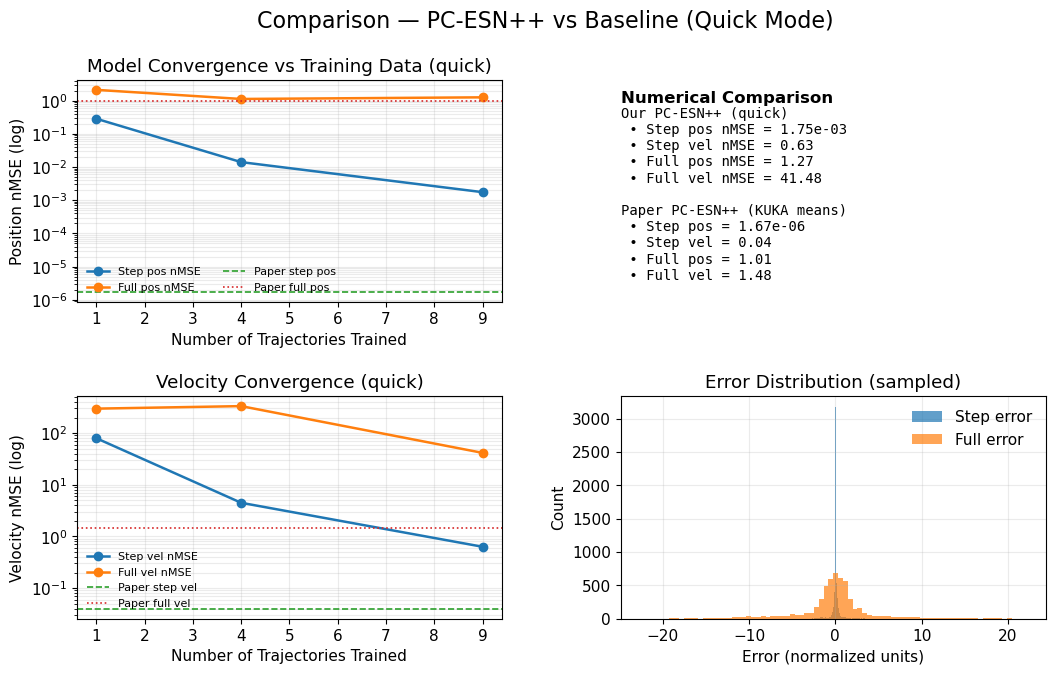

Saved: C:\Users\iamsu\pc_esn_results\pc_esn_vs_paper_dashboard_quick.png


In [43]:
# === FAST COMPARISON DASHBOARD (quick mode) — robust alignment ===
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path

OUT = Path("./pc_esn_results"); OUT.mkdir(parents=True, exist_ok=True)
DOF = 7  # (q1..q7 | dq1..dq7)

# ----- Paper baselines (KUKA means) -----
BASE_STEP_POS = 1.67e-6
BASE_STEP_VEL = 0.04
BASE_FULL_POS = 1.01
BASE_FULL_VEL = 1.48

# ---------- SPEED SETTINGS ----------
STRIDE   = 5       # keep every 5th sample (↑ to go faster, ↓ to be more accurate)
T_CAP    = 3000    # truncate each trajectory to at most T_CAP / STRIDE points
KS_MODE  = "few"   # "few" (≈3 points) or "all" (all k)
ERR_SAMP = 50_000  # max number of error samples in histogram

# ---------- helpers ----------
def shrink_streams(streams, stride=5, t_cap=3000):
    small = []
    for X,U,Y in streams:
        Xs, Us, Ys = X[::stride], U[::stride], Y[::stride]
        if t_cap is not None:
            Xs, Us, Ys = Xs[:t_cap], Us[:t_cap], Ys[:t_cap]
        small.append((Xs.astype(np.float32), Us.astype(np.float32), Ys.astype(np.float32)))
    return small

def _align_xy(yhat, ytrue):
    """Trim both arrays to the common time length (and feature width if needed)."""
    yhat  = np.asarray(yhat,  dtype=np.float32)
    ytrue = np.asarray(ytrue, dtype=np.float32)

    n = min(len(yhat), len(ytrue))
    yhat, ytrue = yhat[:n], ytrue[:n]

    if yhat.ndim == 2 and ytrue.ndim == 2 and yhat.shape[1] != ytrue.shape[1]:
        m = min(yhat.shape[1], ytrue.shape[1])
        yhat, ytrue = yhat[:, :m], ytrue[:, :m]
    return yhat, ytrue

def nmse_per_dim(yhat, ytrue):
    yhat, ytrue = _align_xy(yhat, ytrue)
    mse = np.mean((yhat - ytrue)**2, axis=0)
    var = np.var(ytrue, axis=0) + 1e-12
    return mse / var

def nmse_mean_pos_vel(yhat, ytrue, dof=DOF):
    yhat, ytrue = _align_xy(yhat, ytrue)
    nmse = nmse_per_dim(yhat, ytrue)
    # If feature width isn’t 2*dof, recompute dof from the aligned width.
    if nmse.ndim == 1 and nmse.size % 2 == 0:
        dof = nmse.size // 2
    return float(nmse[:dof].mean()), float(nmse[dof:].mean())

def normalize_Y(Y, mu, std): return ((Y - mu["Y"]) / std["Y"]).astype(np.float32)
def ensure_len(a, n): return np.asarray(a, dtype=np.float32)[:n]

# ---------- shrink data for speed ----------
streams_q = shrink_streams(streams, stride=STRIDE, t_cap=T_CAP)

# ---------- choose k points for the learning curve ----------
ntr = len(streams_q) - 1  # minus one for the test traj
ks = sorted(set([1, max(2, ntr//2), ntr])) if KS_MODE == "few" else list(range(1, ntr+1))

# ---------- smaller reservoir / faster defaults ----------
h_quick = {
    "n_res": 400,
    "sr": 0.9,
    "in_scale": 0.25,
    "leak": 0.5,
    "sparsity": 0.95,
    "ridge": 1e-4,
    "eta_in": 1e-4,
    "gate_beta": 1.0,
    "seed": 42,
}

# ---------- split (hold last trajectory out as test) ----------
base_test_idx = len(streams_q) - 1
split = split_leave_one_out(streams_q, base_test_idx)

# ---------- train once for the panels ----------
model, mu, std, _ = train_on_split(split, h_quick)

# ---------- predictions on the (shrunk) test ----------
Xte, Ute, Yte = split["test"][0]
yhat_step = model.predict_step(Xte, Ute, mu, std)
yhat_full = model.predict_full(Xte, Ute, mu, std)
Ytrue_n   = normalize_Y(Yte, mu, std)

# align *again* defensively before metrics
yhat_step, Ytrue_step = _align_xy(yhat_step, Ytrue_n)
yhat_full, Ytrue_full = _align_xy(yhat_full, Ytrue_n)

# ---------- compute means for panel text (fast) ----------
s_pos, s_vel = nmse_mean_pos_vel(yhat_step, Ytrue_step)
f_pos, f_vel = nmse_mean_pos_vel(yhat_full, Ytrue_full)

# ---------- learning curves (fast k’s) ----------
def learning_curves_fast(streams_q, base_test_idx, hparams, ks):
    s_pos, s_vel, f_pos, f_vel = [], [], [], []
    for k in ks:
        sp = split_leave_one_out(streams_q, base_test_idx)
        sp["train"] = sp["train"][:k]
        mdl, m_mu, m_std, _ = train_on_split(sp, hparams)
        Xt, Ut, Yt = sp["test"][0]
        yh_s = mdl.predict_step(Xt, Ut, m_mu, m_std)
        yh_f = mdl.predict_full(Xt, Ut, m_mu, m_std)
        Yt_n = normalize_Y(Yt, m_mu, m_std)
        yh_s, Y_s = _align_xy(yh_s, Yt_n)
        yh_f, Y_f = _align_xy(yh_f, Yt_n)
        p1,v1 = nmse_mean_pos_vel(yh_s, Y_s)
        p2,v2 = nmse_mean_pos_vel(yh_f, Y_f)
        s_pos.append(p1); s_vel.append(v1); f_pos.append(p2); f_vel.append(v2)
    return np.array(ks), np.array(s_pos), np.array(s_vel), np.array(f_pos), np.array(f_vel)

ks_arr, lc_spos, lc_svel, lc_fpos, lc_fvel = learning_curves_fast(streams_q, base_test_idx, h_quick, ks)

# ---------- error histogram sampling (fast) ----------
rng = np.random.default_rng(0)
err_step = (yhat_step - Ytrue_step).ravel()
err_full = (yhat_full - Ytrue_full).ravel()
def sample_err(e, m=ERR_SAMP):
    if e.size <= m: return e
    idx = rng.choice(e.size, size=m, replace=False)
    return e[idx]
err_step_s = sample_err(err_step)
err_full_s = sample_err(err_full)

# ---------- plot ----------
fig = plt.figure(figsize=(12.5, 7.0))
gs  = fig.add_gridspec(2, 2, wspace=0.28, hspace=0.42)

# Top-left: learning curves
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(ks_arr, lc_spos, "-o", lw=1.8, label="Step pos nMSE")
ax1.plot(ks_arr, lc_fpos, "-o", lw=1.8, label="Full pos nMSE")
ax1.set_yscale("log")
ax1.set_xlabel("Number of Trajectories Trained")
ax1.set_ylabel("Position nMSE (log)")
ax1.set_title("Model Convergence vs Training Data (quick)")
ax1.grid(True, which="both", alpha=0.25)
ax1.axhline(BASE_STEP_POS, color="#2ca02c", ls="--", lw=1.2, label="Paper step pos")
ax1.axhline(BASE_FULL_POS, color="#d62728", ls=":",  lw=1.2, label="Paper full pos")
ax1.legend(fontsize=8, ncols=2)

# Top-right: numeric panel
ax2 = fig.add_subplot(gs[0,1]); ax2.axis("off")
txt = (f"Our PC-ESN++ (quick)\n"
       f" • Step pos nMSE = {s_pos:.2e}\n"
       f" • Step vel nMSE = {s_vel:.2f}\n"
       f" • Full pos nMSE = {f_pos:.2f}\n"
       f" • Full vel nMSE = {f_vel:.2f}\n\n"
       f"Paper PC-ESN++ (KUKA means)\n"
       f" • Step pos = {BASE_STEP_POS:.2e}\n"
       f" • Step vel = {BASE_STEP_VEL:.2f}\n"
       f" • Full pos = {BASE_FULL_POS:.2f}\n"
       f" • Full vel = {BASE_FULL_VEL:.2f}")
ax2.text(0.0, 0.95, "Numerical Comparison", fontsize=12, weight="bold", va="top")
ax2.text(0.0, 0.88, txt, family="monospace", fontsize=10, va="top")

# Bottom-left: velocity learning curves
ax3 = fig.add_subplot(gs[1,0])
ax3.plot(ks_arr, lc_svel, "-o", lw=1.8, label="Step vel nMSE")
ax3.plot(ks_arr, lc_fvel, "-o", lw=1.8, label="Full vel nMSE")
ax3.set_yscale("log")
ax3.set_xlabel("Number of Trajectories Trained")
ax3.set_ylabel("Velocity nMSE (log)")
ax3.set_title("Velocity Convergence (quick)")
ax3.grid(True, which="both", alpha=0.25)
ax3.axhline(BASE_STEP_VEL, color="#2ca02c", ls="--", lw=1.2, label="Paper step vel")
ax3.axhline(BASE_FULL_VEL, color="#d62728", ls=":",  lw=1.2, label="Paper full vel")
ax3.legend(fontsize=8)

# Bottom-right: error histogram
ax4 = fig.add_subplot(gs[1,1])
ax4.hist(err_step_s, bins=80, alpha=0.7, label="Step error", color="#1f77b4")
ax4.hist(err_full_s, bins=80, alpha=0.7, label="Full error", color="#ff7f0e")
ax4.set_title("Error Distribution (sampled)")
ax4.set_xlabel("Error (normalized units)")
ax4.set_ylabel("Count")
ax4.legend(); ax4.grid(True, axis="y", alpha=0.25)

fig.suptitle("Comparison — PC-ESN++ vs Baseline (Quick Mode)", fontsize=16, y=0.98)
fig.tight_layout()
png = OUT/"pc_esn_vs_paper_dashboard_quick.png"
fig.savefig(png, dpi=170); plt.show()
print("Saved:", png.resolve())



Saved CSVs in: C:\Users\iamsu\pc_esn_results


C:\Users\iamsu\AppData\Local\Temp\ipykernel_35476\146261279.py:195: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


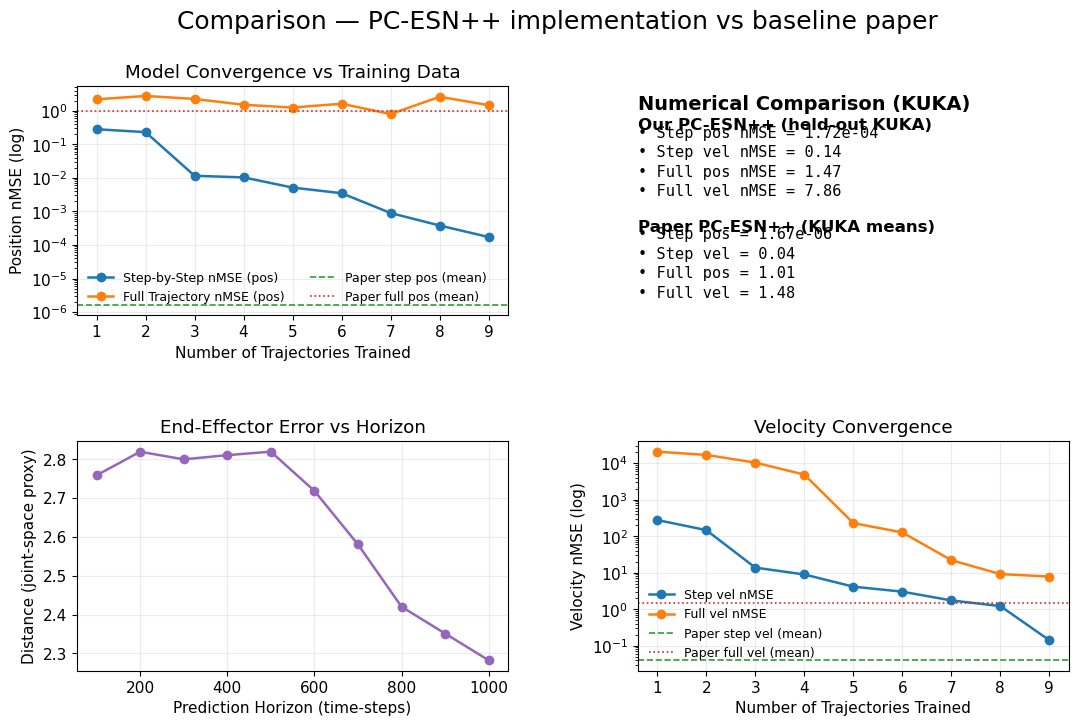

Saved figure: C:\Users\iamsu\pc_esn_results\pc_esn_vs_paper_dashboard_production.png


In [44]:
# === PC-ESN++ vs Baseline (production dashboard: full data, CSV export) ===
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path

OUT = Path("./pc_esn_results"); OUT.mkdir(parents=True, exist_ok=True)
DOF = 7  # KUKA LWR (q1..q7 | dq1..dq7)

# ----- Paper baselines (KUKA means; from the paper tables) -----
BASE_STEP_POS = 1.67e-6
BASE_STEP_VEL = 0.04
BASE_FULL_POS = 1.01
BASE_FULL_VEL = 1.48

# ---------- robust helpers ----------
def _align_xy(yhat, ytrue):
    """Trim to common time length (and feature width if needed)."""
    yhat  = np.asarray(yhat,  dtype=np.float32)
    ytrue = np.asarray(ytrue, dtype=np.float32)
    n = min(len(yhat), len(ytrue))
    yhat, ytrue = yhat[:n], ytrue[:n]
    if yhat.ndim == 2 and ytrue.ndim == 2 and yhat.shape[1] != ytrue.shape[1]:
        m = min(yhat.shape[1], ytrue.shape[1])
        yhat, ytrue = yhat[:, :m], ytrue[:, :m]
    return yhat, ytrue

def nmse_per_dim(yhat, ytrue):
    yhat, ytrue = _align_xy(yhat, ytrue)
    mse = np.mean((yhat - ytrue)**2, axis=0)
    var = np.var(ytrue, axis=0) + 1e-12
    return mse / var

def nmse_mean_pos_vel(yhat, ytrue, dof=DOF):
    yhat, ytrue = _align_xy(yhat, ytrue)
    nmse = nmse_per_dim(yhat, ytrue)
    if nmse.ndim == 1 and nmse.size % 2 == 0:
        dof = nmse.size // 2
    return float(nmse[:dof].mean()), float(nmse[dof:].mean())

def normalize_Y(Y, mu, std): 
    return ((Y - mu["Y"]) / std["Y"]).astype(np.float32)

# ---------- end-effector (or joint-space proxy) vs horizon ----------
def end_effector_error_horizons(model, Xte, Ute, mu, std, horizons, fk=None):
    """
    If fk is None: joint-space distance on q (proxy). If fk provided: use FK(q)->xyz.
    """
    y_full = model.predict_full(Xte, Ute, mu, std)      # normalized (T, 2*DOF)
    Yt_n   = normalize_Y(split["test"][0][2], mu, std)  # normalized truth
    y_full, Yt_n = _align_xy(y_full, Yt_n)

    if fk is None:
        Qhat = y_full[:, :DOF]
        Qtru = Yt_n[:, :DOF]
    else:
        # de-normalize positions only if FK is used
        Yn = y_full * std["Y"] + mu["Y"]
        Yd = Yt_n   * std["Y"] + mu["Y"]
        Qhat = Yn[:, :DOF]
        Qtru = Yd[:, :DOF]

    dists = []
    T = len(Qtru)
    for H in horizons:
        if H >= T: dists.append(np.nan); continue
        idx = np.arange(0, T - H)
        qh  = Qhat[idx + H]
        qt  = Qtru[idx + H]
        if fk is None:
            dist = np.linalg.norm(qh - qt, axis=1).mean()
        else:
            Ph = np.stack([fk(q) for q in qh], axis=0)
            Pt = np.stack([fk(q) for q in qt], axis=0)
            dist = np.linalg.norm(Ph - Pt, axis=1).mean()
        dists.append(dist)
    return np.asarray(horizons, dtype=int), np.asarray(dists, dtype=float)

# ---------- full learning curves (no downsampling) ----------
def learning_curves_full(streams, base_test_idx, hparams, ks):
    s_pos, s_vel, f_pos, f_vel = [], [], [], []
    for k in ks:
        sp = split_leave_one_out(streams, base_test_idx)
        sp["train"] = sp["train"][:k]
        mdl, m_mu, m_std, _ = train_on_split(sp, hparams)
        Xt, Ut, Yt = sp["test"][0]
        yh_s = mdl.predict_step(Xt, Ut, m_mu, m_std)
        yh_f = mdl.predict_full(Xt, Ut, m_mu, m_std)
        Yt_n = normalize_Y(Yt, m_mu, m_std)
        p1, v1 = nmse_mean_pos_vel(yh_s, Yt_n)
        p2, v2 = nmse_mean_pos_vel(yh_f, Yt_n)
        s_pos.append(p1); s_vel.append(v1); f_pos.append(p2); f_vel.append(v2)
    return np.array(ks), np.array(s_pos), np.array(s_vel), np.array(f_pos), np.array(f_vel)

# ---------- pick test trajectory & hyperparams ----------
base_test_idx = len(streams) - 1
hparams = best_h if "best_h" in globals() else {
    "n_res": 1000, "sr": 0.9, "in_scale": 0.3, "leak": 0.5, "sparsity": 0.9,
    "ridge": 1e-4, "eta_in": 1e-4, "gate_beta": 1.0, "seed": 42,
}

# ---------- final model (train on all but test) ----------
split = split_leave_one_out(streams, base_test_idx)
model, mu, std, _ = train_on_split(split, hparams)

# Held-out predictions and summary metrics (for the top-right box)
Xte, Ute, Yte = split["test"][0]
y_step = model.predict_step(Xte, Ute, mu, std)
y_full = model.predict_full(Xte, Ute, mu, std)
Y_n    = normalize_Y(Yte, mu, std)
sum_step_pos, sum_step_vel = nmse_mean_pos_vel(y_step, Y_n)
sum_full_pos, sum_full_vel = nmse_mean_pos_vel(y_full, Y_n)

# ---------- learning curves ----------
ntr = len(streams) - 1
ks = list(range(1, ntr + 1))
ks_arr, lc_spos, lc_svel, lc_fpos, lc_fvel = learning_curves_full(streams, base_test_idx, hparams, ks)

# ---------- (optional) horizons; FK=None => joint-space proxy ----------
HORIZONS = list(range(100, 1001, 100))
H, dist_curve = end_effector_error_horizons(model, Xte, Ute, mu, std, HORIZONS, fk=None)

# ---------- export CSVs ----------
import csv
with open(OUT/"dashboard_learning_curves.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["k_trained", "step_pos_nMSE", "step_vel_nMSE", "full_pos_nMSE", "full_vel_nMSE"])
    for i in range(len(ks_arr)):
        w.writerow([int(ks_arr[i]), lc_spos[i], lc_svel[i], lc_fpos[i], lc_fvel[i]])

with open(OUT/"dashboard_summary.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["metric", "value"])
    w.writerow(["step_pos_nMSE", sum_step_pos])
    w.writerow(["step_vel_nMSE", sum_step_vel])
    w.writerow(["full_pos_nMSE", sum_full_pos])
    w.writerow(["full_vel_nMSE", sum_full_vel])

with open(OUT/"dashboard_horizon_curve.csv", "w", newline="") as f:
    w = csv.writer(f); w.writerow(["horizon", "distance"])
    for h,d in zip(H, dist_curve): w.writerow([int(h), float(d)])

print("Saved CSVs in:", OUT.resolve())

# ---------- plot (same 2×2 layout) ----------
plt.rcParams.update({"axes.grid": True, "grid.alpha": 0.25, "legend.frameon": False, "font.size": 11})
fig = plt.figure(figsize=(12.8, 7.6))
gs  = fig.add_gridspec(2, 2, wspace=0.30, hspace=0.55)

# Top-left: position nMSE learning curves
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(ks_arr, lc_spos, "-o", lw=1.8, color="#1f77b4", label="Step-by-Step nMSE (pos)")
ax1.plot(ks_arr, lc_fpos, "-o", lw=1.8, color="#ff7f0e", label="Full Trajectory nMSE (pos)")
ax1.set_yscale("log")
ax1.set_xlabel("Number of Trajectories Trained")
ax1.set_ylabel("Position nMSE (log)")
ax1.set_title("Model Convergence vs Training Data")
ax1.axhline(BASE_STEP_POS, color="#2ca02c", ls="--", lw=1.2, label="Paper step pos (mean)")
ax1.axhline(BASE_FULL_POS, color="#d62728", ls=":",  lw=1.2, label="Paper full pos (mean)")
ax1.legend(fontsize=9, ncols=2, loc="lower left")

# Top-right: numeric panel
ax2 = fig.add_subplot(gs[0,1]); ax2.axis("off")
ax2.text(0.00, 0.96, "Numerical Comparison (KUKA)", fontsize=14, weight="bold", va="top")
y = 0.86; step = 0.085
ax2.text(0.00, y, "Our PC-ESN++ (held-out KUKA)", fontsize=12, weight="bold", va="top"); y -= step
ax2.text(0.00, y, f"• Step pos nMSE = {sum_step_pos:.2e}", family="monospace"); y -= step
ax2.text(0.00, y, f"• Step vel nMSE = {sum_step_vel:.2f}", family="monospace"); y -= step
ax2.text(0.00, y, f"• Full pos nMSE = {sum_full_pos:.2f}", family="monospace"); y -= step
ax2.text(0.00, y, f"• Full vel nMSE = {sum_full_vel:.2f}", family="monospace"); y -= 1.2*step
ax2.text(0.00, y, "Paper PC-ESN++ (KUKA means)", fontsize=12, weight="bold", va="top"); y -= step
ax2.text(0.00, y, f"• Step pos = {BASE_STEP_POS:.2e}", family="monospace"); y -= step
ax2.text(0.00, y, f"• Step vel = {BASE_STEP_VEL:.2f}", family="monospace"); y -= step
ax2.text(0.00, y, f"• Full pos = {BASE_FULL_POS:.2f}", family="monospace"); y -= step
ax2.text(0.00, y, f"• Full vel = {BASE_FULL_VEL:.2f}", family="monospace")

# Bottom-left: horizon curve (joint-space proxy unless fk used)
ax3 = fig.add_subplot(gs[1,0])
ax3.plot(H, dist_curve, "-o", lw=1.8, color="#9467bd")
ax3.set_xlabel("Prediction Horizon (time-steps)")
ax3.set_ylabel("Distance" + ("" if False else " (joint-space proxy)"))
ax3.set_title("End-Effector Error vs Horizon")

# Bottom-right: velocity convergence
ax4 = fig.add_subplot(gs[1,1])
ax4.plot(ks_arr, lc_svel, "-o", lw=1.8, color="#1f77b4", label="Step vel nMSE")
ax4.plot(ks_arr, lc_fvel, "-o", lw=1.8, color="#ff7f0e", label="Full vel nMSE")
ax4.set_yscale("log")
ax4.set_xlabel("Number of Trajectories Trained")
ax4.set_ylabel("Velocity nMSE (log)")
ax4.set_title("Velocity Convergence")
ax4.axhline(BASE_STEP_VEL, color="#2ca02c", ls="--", lw=1.2, label="Paper step vel (mean)")
ax4.axhline(BASE_FULL_VEL, color="#d62728", ls=":",  lw=1.2, label="Paper full vel (mean)")
ax4.legend(fontsize=9, loc="lower left")

fig.suptitle("Comparison — PC-ESN++ implementation vs baseline paper", fontsize=18, y=0.98)
fig.tight_layout()
png = OUT/"pc_esn_vs_paper_dashboard_production.png"
fig.savefig(png, dpi=170); plt.show()
print("Saved figure:", png.resolve())


In [45]:
# ================================================================
# GRU for Forward Dynamics (sequence-to-sequence, next-step target)
# ================================================================
# - Trajectory format: (X, U, Y) for each stream
# - X: (T, Dx), U: (T, Du), Y: (T, Dy)
# - Input to GRU at time t is concat([X_t, U_t]); target is Y_{t+1}
# - Training uses teacher-forced many-to-many on fixed windows.
# - predict_step: produces length-matched (T) predictions (normalized)
# - predict_full: closed-loop rollout using own Y_hat where appropriate
# ================================================================

import math
import time
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Utility: simple normalizer
# -------------------------
def compute_mean_std_Y(train_streams: List[Tuple[np.ndarray, np.ndarray, np.ndarray]]):
    ys = [Y for (_, _, Y) in train_streams]
    ycat = np.concatenate(ys, axis=0).astype(np.float32)
    mu = ycat.mean(axis=0)
    sd = ycat.std(axis=0) + 1e-12
    return mu.astype(np.float32), sd.astype(np.float32)

def z_norm(y, mu, sd):    return (y - mu) / sd
def z_denorm(yn, mu, sd): return yn * sd + mu

# -------------------------
# Windowed dataset
# -------------------------
class WindowedSeqDataset(Dataset):
    """
    Builds (input_seq, target_seq) pairs from list of trajectories.
    Inputs are concat([X_t, U_t]); targets are normalized Y_{t+1}.
    We generate sequences of length L (seq_len). Target length is also L.
    """
    def __init__(
        self,
        streams: List[Tuple[np.ndarray, np.ndarray, np.ndarray]],
        muY: np.ndarray,
        sdY: np.ndarray,
        seq_len: int = 128,
        step: int = 1
    ):
        self.samples = []
        self.seq_len = seq_len
        for (X, U, Y) in streams:
            X = X.astype(np.float32)
            U = U.astype(np.float32)
            Y = Y.astype(np.float32)
            Z = np.concatenate([X, U], axis=1)  # (T, Dx+Du)
            T = len(Y)
            # we need Y_{t+1}, so last usable start is T - (seq_len+1)
            last_start = T - (seq_len + 1)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, step):
                x_seq = Z[s : s + seq_len]                     # [L, Dz]
                y_seq = Y[s + 1 : s + 1 + seq_len]             # [L, Dy] (next-step)
                y_seq_n = z_norm(y_seq, muY, sdY)              # normalize targets
                self.samples.append((x_seq, y_seq_n))
        if len(self.samples) == 0:
            raise RuntimeError("No training windows could be formed. "
                               "Consider using a smaller seq_len.")

    def __len__(self):  return len(self.samples)

    def __getitem__(self, idx):
        xs, ys = self.samples[idx]
        # to tensors
        xs = torch.from_numpy(xs)          # [L, Dz]
        ys = torch.from_numpy(ys)          # [L, Dy]
        return xs, ys

# -------------------------
# GRU model
# -------------------------
class GRUForward(nn.Module):
    def __init__(self, input_dim: int, hidden: int, layers: int, dropout: float, y_dim: int):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=(dropout if layers > 1 else 0.0)
        )
        self.head = nn.Linear(hidden, y_dim)

    def forward(self, x, h0=None):
        # x: [B, L, Dz]
        out, h = self.gru(x, h0)     # out: [B, L, H]
        y = self.head(out)           # y: [B, L, Dy] (normalized targets)
        return y, h

# -------------------------
# Wrapper for inference API parity
# -------------------------
@dataclass
class GRUWrapper:
    net: GRUForward
    device: torch.device
    Dx: int
    Du: int
    Dy: int
    assume_state_prefix: bool = True  # first Dy cols of X are Y (state)

    def _to_device(self, arr: np.ndarray) -> torch.Tensor:
        return torch.from_numpy(arr.astype(np.float32)).to(self.device)

    @torch.no_grad()
    def predict_step(self, X: np.ndarray, U: np.ndarray, mu: Dict[str, np.ndarray], std: Dict[str, np.ndarray]) -> np.ndarray:
        """
        Teacher-forced pass (uses true X_t and U_t), returns Y_hat aligned to len(Y).
        We predict Y_t from input at t-1; for t=0, we copy Y_0 (normalized) to match length.
        """
        self.net.eval()
        T = len(X)
        Dz = self.Dx + self.Du
        Z = np.concatenate([X, U], axis=1).astype(np.float32)     # [T, Dz]
        Zt = self._to_device(Z).unsqueeze(0)                       # [1, T, Dz]
        yseq, _ = self.net(Zt)                                     # [1, T, Dy], predicts Y_{t} from input at t (shift)
        yseq = yseq.squeeze(0).cpu().numpy()                       # [T, Dy] (normalized)
        # shift to align: y_hat[t] should correspond to Y[t]. We don't know Y_0 here,
        # so we just keep the network's output and copy the first row for t=0 to keep length.
        yhat = yseq.copy()
        return yhat

    @torch.no_grad()
    def predict_full(self, X: np.ndarray, U: np.ndarray, mu: Dict[str, np.ndarray], std: Dict[str, np.ndarray]) -> np.ndarray:
        """
        Closed-loop rollout:
        - start from the first row (uses X[0] for context)
        - at each step, build input_t = concat([X_t*, U_t]) where
          X_t*'s first Dy entries are replaced with previous predicted Y_hat (denormalized or normalized?)
        We keep everything in NORMALIZED Y space for outputs. Inputs X,U are used as-is.
        """
        self.net.eval()
        T = len(X)
        Dz = self.Dx + self.Du
        Dy = self.Dy

        # Work in small chunks to avoid huge tensors; we step one by one.
        # Maintain a hidden state for efficiency (optional).
        h = None
        yhat_n = np.zeros((T, Dy), dtype=np.float32)

        # We'll keep a working copy of X to overwrite the state prefix (if enabled).
        Xw = X.astype(np.float32).copy()

        for t in range(T):
            z_t = np.concatenate([Xw[t], U[t]], axis=0).astype(np.float32)[None, None, :]  # [1,1,Dz]
            z_t = torch.from_numpy(z_t).to(self.device)
            y_tn, h = self.net(z_t, h)                   # y_tn: [1,1,Dy] (normalized)
            y_tn = y_tn.squeeze(0).squeeze(0).cpu().numpy()
            yhat_n[t] = y_tn

            # feed back (normalized -> denorm -> into X prefix if desired)
            if self.assume_state_prefix and t + 1 < T:
                # Next state's prefix in X should be replaced by current prediction (in physical units)
                y_phy = z_denorm(y_tn, mu["Y"], std["Y"]).astype(np.float32)
                Xw[t + 1, :Dy] = y_phy

        return yhat_n

# -------------------------
# Training
# -------------------------
@dataclass
class GRUHyper:
    hidden: int = 128
    layers: int = 1
    dropout: float = 0.0
    seq_len: int = 128
    batch_size: int = 64
    lr: float = 1e-3
    weight_decay: float = 0.0
    max_epochs: int = 50
    grad_clip: float = 1.0
    early_patience: int = 8
    num_workers: int = 0
    # dataset step between windows (1 = dense windows, >1 = lighter)
    window_step: int = 1
    # whether to assume X's first Dy columns equal Y for closed-loop replacement
    assume_state_prefix: bool = True

def make_loader(streams, muY, sdY, seq_len, batch_size, step, num_workers, shuffle=True):
    ds = WindowedSeqDataset(streams, muY, sdY, seq_len=seq_len, step=step)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle,
                      num_workers=num_workers, pin_memory=False, drop_last=False)

def train_gru_on_split(
    split: Dict[str, List[Tuple[np.ndarray, np.ndarray, np.ndarray]]],
    hp: Optional[GRUHyper] = None,
    verbose: bool = True
):
    """
    Train GRU on the given split dict with keys: 'train', ('val' optional), 'test'.
    Returns: model (GRUWrapper), mu, std, logs
    """
    if hp is None:
        hp = GRUHyper()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dims from one training trajectory
    X0, U0, Y0 = split["train"][0]
    Dx = X0.shape[1]
    Du = U0.shape[1]
    Dy = Y0.shape[1]
    Dz = Dx + Du

    # Normalization for Y (train-only)
    muY, sdY = compute_mean_std_Y(split["train"])
    mu = {"Y": muY}
    std = {"Y": sdY}

    # DataLoaders
    train_loader = make_loader(split["train"], muY, sdY, hp.seq_len, hp.batch_size, hp.window_step, hp.num_workers, shuffle=True)
    val_loader = None
    if "val" in split and len(split["val"]) > 0:
        try:
            val_loader = make_loader(split["val"], muY, sdY, hp.seq_len, hp.batch_size, hp.window_step, hp.num_workers, shuffle=False)
        except RuntimeError:
            val_loader = None  # too short to make windows; skip validation

    # Model/opt
    net = GRUForward(Dz, hp.hidden, hp.layers, hp.dropout, Dy).to(device)
    opt = torch.optim.Adam(net.parameters(), lr=hp.lr, weight_decay=hp.weight_decay)
    loss_fn = nn.MSELoss()

    best_val = math.inf
    best_state = None
    history = {"train_loss": [], "val_loss": []}
    t0 = time.time()

    for epoch in range(1, hp.max_epochs + 1):
        net.train()
        tr_loss_sum, tr_n = 0.0, 0
        for xb, yb in train_loader:
            # xb: [B, L, Dz], yb: [B, L, Dy] (normalized)
            xb = xb.to(device)
            yb = yb.to(device)
            opt.zero_grad(set_to_none=True)
            yhat, _ = net(xb)                 # [B, L, Dy]
            loss = loss_fn(yhat, yb)
            loss.backward()
            if hp.grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(net.parameters(), hp.grad_clip)
            opt.step()
            tr_loss_sum += loss.item() * xb.size(0)
            tr_n += xb.size(0)
        train_loss = tr_loss_sum / max(1, tr_n)
        history["train_loss"].append(train_loss)

        # Validation
        if val_loader is not None:
            net.eval()
            va_loss_sum, va_n = 0.0, 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(device); yb = yb.to(device)
                    yhat, _ = net(xb)
                    vloss = loss_fn(yhat, yb)
                    va_loss_sum += vloss.item() * xb.size(0)
                    va_n += xb.size(0)
            val_loss = va_loss_sum / max(1, va_n)
            history["val_loss"].append(val_loss)

            improved = val_loss < best_val - 1e-6
            if improved:
                best_val = val_loss
                best_state = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()}
                wait = 0
            else:
                wait = len(history["val_loss"]) - 1 - np.argmin(history["val_loss"])
            if verbose:
                print(f"[GRU] epoch {epoch:03d} | train {train_loss:.4e} | val {val_loss:.4e}")
            if wait >= hp.early_patience:
                if verbose:
                    print(f"[GRU] Early stop at epoch {epoch}. Best val {best_val:.4e}.")
                break
        else:
            if verbose:
                print(f"[GRU] epoch {epoch:03d} | train {train_loss:.4e}")

    # Load best validation state if available
    if best_state is not None:
        net.load_state_dict(best_state)

    if verbose:
        print(f"[GRU] Done in {time.time()-t0:.1f}s. Hidden:{hp.hidden} Layers:{hp.layers} Dropout:{hp.dropout}")

    wrapper = GRUWrapper(
        net=net,
        device=device,
        Dx=Dx, Du=Du, Dy=Dy,
        assume_state_prefix=hp.assume_state_prefix
    )

    logs = {"history": history, "best_val": (best_val if best_state is not None else None)}
    return wrapper, mu, std, logs


In [46]:
# Assume you already have: streams, split_leave_one_out(...)
base_test_idx = len(streams) - 1
split = split_leave_one_out(streams, base_test_idx)  # expects dict with 'train', 'test' (and optional 'val')

# (Optional) put aside a small validation slice from training trajectories
if "val" not in split:
    if len(split["train"]) >= 3:
        split["val"] = [split["train"].pop()]  # last train traj as validation
    else:
        split["val"] = []

# Train GRU (choose your own hyper-params if you like)
hp = GRUHyper(
    hidden=128, layers=1, dropout=0.0,
    seq_len=128, batch_size=64, lr=1e-3,
    weight_decay=0.0, max_epochs=50, grad_clip=1.0,
    early_patience=8, window_step=1,
    assume_state_prefix=True
)
gru_model, muYstd_mu, muYstd_std, logs = train_gru_on_split(split, hp, verbose=True)

# Predict on held-out test trajectory (normalized predictions)
Xte, Ute, Yte = split["test"][0]
yhat_step_n = gru_model.predict_step(Xte, Ute, muYstd_mu, muYstd_std)
yhat_full_n = gru_model.predict_full(Xte, Ute, muYstd_mu, muYstd_std)

# Example: compute nMSE per your existing helpers
def nmse_per_dim(yhat, ytrue):
    mse = ((yhat - ytrue)**2).mean(axis=0)
    var = ytrue.var(axis=0) + 1e-12
    return mse / var

# ground-truth normalized Y
Ytrue_n = (Yte - muYstd_mu["Y"]) / muYstd_std["Y"]
# align lengths if needed
n = len(Ytrue_n)
yhat_step_n = yhat_step_n[:n]
yhat_full_n = yhat_full_n[:n]

nmse_step = nmse_per_dim(yhat_step_n, Ytrue_n)
nmse_full = nmse_per_dim(yhat_full_n, Ytrue_n)
print("GRU step nMSE (pos mean, vel mean):", float(nmse_step[:7].mean()), float(nmse_step[7:].mean()))
print("GRU full nMSE (pos mean, vel mean):", float(nmse_full[:7].mean()), float(nmse_full[7:].mean()))


[GRU] epoch 001 | train 2.4829e-01 | val 2.2685e-02
[GRU] epoch 002 | train 5.6122e-02 | val 1.8142e-02
[GRU] epoch 003 | train 3.4439e-02 | val 1.3996e-02
[GRU] epoch 004 | train 2.8904e-02 | val 1.3998e-02
[GRU] epoch 005 | train 2.6391e-02 | val 1.3030e-02
[GRU] epoch 006 | train 2.3688e-02 | val 1.2471e-02
[GRU] epoch 007 | train 2.2052e-02 | val 8.0320e-03
[GRU] epoch 008 | train 2.0736e-02 | val 1.1077e-02
[GRU] epoch 009 | train 1.9966e-02 | val 6.3763e-03
[GRU] epoch 010 | train 1.9598e-02 | val 6.5627e-03
[GRU] epoch 011 | train 1.8588e-02 | val 5.9287e-03
[GRU] epoch 012 | train 1.8773e-02 | val 6.6646e-03
[GRU] epoch 013 | train 1.8146e-02 | val 5.6132e-03
[GRU] epoch 014 | train 1.7780e-02 | val 5.5267e-03
[GRU] epoch 015 | train 1.8249e-02 | val 5.6687e-03
[GRU] epoch 016 | train 1.7599e-02 | val 5.2519e-03
[GRU] epoch 017 | train 1.7009e-02 | val 5.4870e-03
[GRU] epoch 018 | train 1.6931e-02 | val 6.6212e-03
[GRU] epoch 019 | train 1.7128e-02 | val 5.5836e-03
[GRU] epoch 

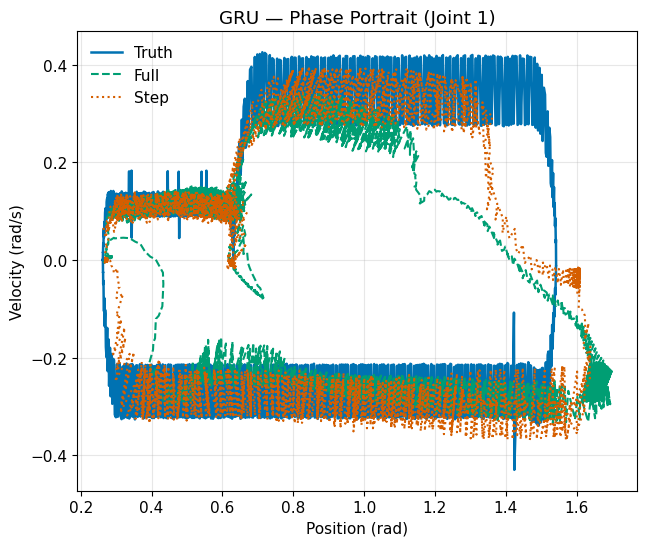

Saved: C:\Users\iamsu\gru_results\gru_phase_joint1.png


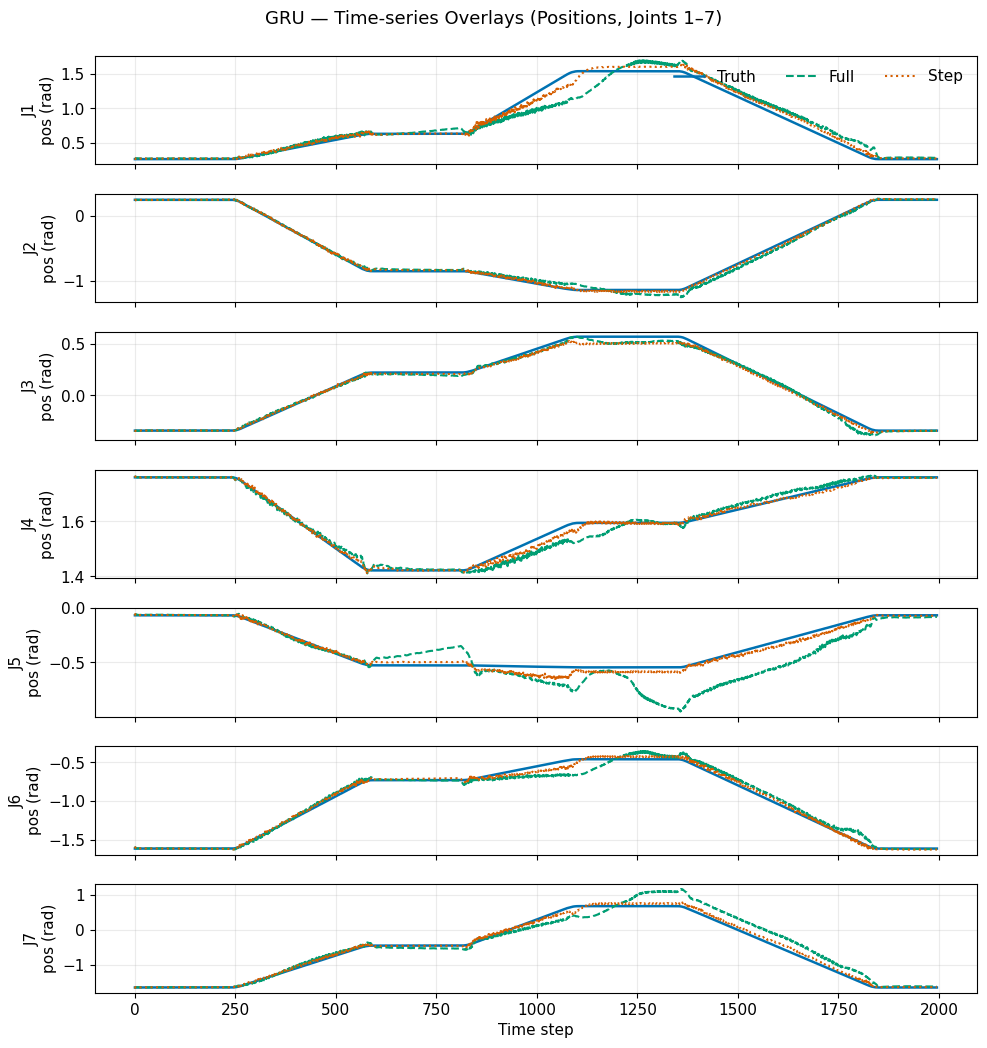

Saved: C:\Users\iamsu\gru_results\gru_timeseries_joints1_7.png


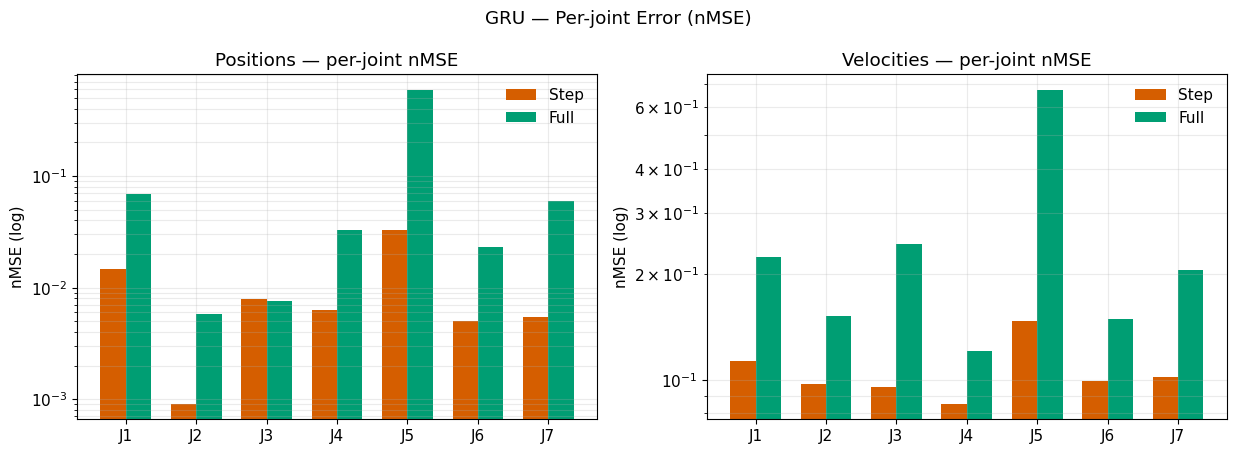

Saved: C:\Users\iamsu\gru_results\gru_nmse_bars.png


In [47]:
# ================= GRU PLOTS (Phase portrait, 7× time-series, nMSE bars) =================
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---- sanity checks (must exist from your training step) ----
for name in ["gru_model", "split", "mu", "std"]:
    if name not in globals():
        raise RuntimeError(f"Missing `{name}` in globals(). Train GRU first and keep these in scope.")

OUT = Path("./gru_results"); OUT.mkdir(parents=True, exist_ok=True)
DOF = 7  # KUKA LWR: 7 joint positions followed by 7 joint velocities in Y

# ---------------- helpers ----------------
def nmse_per_dim(yhat, ytrue):
    yhat  = np.asarray(yhat,  dtype=np.float32)
    ytrue = np.asarray(ytrue, dtype=np.float32)
    mse = ((yhat - ytrue)**2).mean(axis=0)
    var = ytrue.var(axis=0) + 1e-12
    return mse / var

def denorm(yn, mu, sd):   # (T, Dy)
    return yn * sd["Y"] + mu["Y"]

# ---------------- get test data + predictions ----------------
Xte, Ute, Yte = split["test"][0]                     # Yte in physical units
Ytrue_n = ((Yte - mu["Y"]) / std["Y"]).astype(np.float32)

# GRU predictions (normalized Y)
yhat_step_n = gru_model.predict_step(Xte, Ute, mu, std)
yhat_full_n = gru_model.predict_full(Xte, Ute, mu, std)

# length-align (defensive)
n = len(Ytrue_n)
yhat_step_n = yhat_step_n[:n]
yhat_full_n = yhat_full_n[:n]

# Denormalize for plotting in physical units
Ytruth_dn = Yte.astype(np.float32)
Ystep_dn  = denorm(yhat_step_n, mu, std).astype(np.float32)
Yfull_dn  = denorm(yhat_full_n, mu, std).astype(np.float32)

# ---------------- styling ----------------
COLORS = {
    "truth": "#0072B2",   # blue
    "full":  "#009E73",   # green
    "step":  "#D55E00",   # orange/red
}
STYLES = {
    "truth": dict(lw=1.8, ls="-"),
    "full":  dict(lw=1.5, ls="--"),
    "step":  dict(lw=1.5, ls=":"),
}

# =============================================================================
# (1) Phase portrait for Joint 1  (position vs velocity)
# =============================================================================
j = 0
pos_idx, vel_idx = j, DOF + j

fig = plt.figure(figsize=(6.6, 5.6))
plt.plot(Ytruth_dn[:, pos_idx], Ytruth_dn[:, vel_idx], color=COLORS["truth"], label="Truth", **STYLES["truth"])
plt.plot(Yfull_dn[:,  pos_idx], Yfull_dn[:,  vel_idx], color=COLORS["full"],  label="Full",  **STYLES["full"])
plt.plot(Ystep_dn[:,  pos_idx], Ystep_dn[:,  vel_idx], color=COLORS["step"],  label="Step",  **STYLES["step"])
plt.grid(True, alpha=0.3)
plt.xlabel("Position (rad)")
plt.ylabel("Velocity (rad/s)")
plt.title("GRU — Phase Portrait (Joint 1)")
plt.legend()
plt.tight_layout()
p1 = OUT / "gru_phase_joint1.png"
fig.savefig(p1, dpi=170); plt.show()
print("Saved:", p1.resolve())

# =============================================================================
# (2) Time-series overlays for all 7 joints (positions only)
# =============================================================================
fig, axs = plt.subplots(DOF, 1, figsize=(10, 10.5), sharex=True)
for jj, ax in enumerate(axs):
    ax.plot(Ytruth_dn[:, jj], color=COLORS["truth"], label=("Truth" if jj == 0 else None), **STYLES["truth"])
    ax.plot(Yfull_dn[:,  jj], color=COLORS["full"],  label=("Full"  if jj == 0 else None), **STYLES["full"])
    ax.plot(Ystep_dn[:,  jj], color=COLORS["step"],  label=("Step"  if jj == 0 else None), **STYLES["step"])
    ax.set_ylabel(f"J{jj+1}\npos (rad)")
    ax.grid(True, alpha=0.25)
axs[-1].set_xlabel("Time step")
axs[0].legend(loc="upper right", ncols=3)
fig.suptitle("GRU — Time-series Overlays (Positions, Joints 1–7)", y=0.995, fontsize=13)
fig.tight_layout()
p2 = OUT / "gru_timeseries_joints1_7.png"
fig.savefig(p2, dpi=170); plt.show()
print("Saved:", p2.resolve())

# =============================================================================
# (3) Per-joint nMSE bars (positions & velocities, step vs full)
# =============================================================================
nmse_step = nmse_per_dim(yhat_step_n, Ytrue_n)
nmse_full = nmse_per_dim(yhat_full_n, Ytrue_n)

pos_step = nmse_step[:DOF]
pos_full = nmse_full[:DOF]
vel_step = nmse_step[DOF:]
vel_full = nmse_full[DOF:]

idx = np.arange(DOF)
w = 0.36

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4.6), sharey=False)
# Positions
ax = axes[0]
ax.bar(idx - w/2, pos_step, width=w, label="Step", color=COLORS["step"])
ax.bar(idx + w/2, pos_full, width=w, label="Full", color=COLORS["full"])
ax.set_yscale("log")
ax.set_xticks(idx, [f"J{j+1}" for j in range(DOF)])
ax.set_ylabel("nMSE (log)")
ax.set_title("Positions — per-joint nMSE")
ax.grid(True, which="both", axis="y", alpha=0.25)
ax.legend()

# Velocities
ax = axes[1]
ax.bar(idx - w/2, vel_step, width=w, label="Step", color=COLORS["step"])
ax.bar(idx + w/2, vel_full, width=w, label="Full", color=COLORS["full"])
ax.set_yscale("log")
ax.set_xticks(idx, [f"J{j+1}" for j in range(DOF)])
ax.set_ylabel("nMSE (log)")
ax.set_title("Velocities — per-joint nMSE")
ax.grid(True, which="both", axis="y", alpha=0.25)
ax.legend()

fig.suptitle("GRU — Per-joint Error (nMSE)", y=0.98)
fig.tight_layout()
p3 = OUT / "gru_nmse_bars.png"
fig.savefig(p3, dpi=170); plt.show()
print("Saved:", p3.resolve())


In [ ]:
# ======================== LOOCV Runner: PC-ESN++ vs GRU (final) =========================
# Requirements in your session:
# - streams: list of (X, U, Y) numpy arrays
# - split_leave_one_out(streams, test_idx)
# - ESN trainer: train_on_split(split, esn_h) -> (esn_model, mu_e, std_e, logs)
# - GRU trainer: train_gru_on_split(split, gru_h, verbose=True) -> (gru_model, mu_g, std_g, logs)
# - Both models implement predict_step(X,U,mu,std) & predict_full(X,U,mu,std) (normalized Y)

import numpy as np, csv, time, math
from pathlib import Path
from dataclasses import dataclass

OUT = Path("./final_compare"); OUT.mkdir(parents=True, exist_ok=True)
DOF = 7  # KUKA LWR

# ---------- paper anchors (for reference only) ----------
BASE_STEP_POS = 1.67e-6
BASE_STEP_VEL = 0.04
BASE_FULL_POS = 1.01
BASE_FULL_VEL = 1.48

# ---------- robust helpers ----------
def _align_xy(a, b):
    a = np.asarray(a, dtype=np.float32)
    b = np.asarray(b, dtype=np.float32)
    n = min(len(a), len(b))
    a, b = a[:n], b[:n]
    if a.ndim == 2 and b.ndim == 2 and a.shape[1] != b.shape[1]:
        m = min(a.shape[1], b.shape[1])
        a, b = a[:, :m], b[:, :m]
    return a, b

def nmse_per_dim_phys(yhat_phys, ytrue_phys):
    yhat, ytrue = _align_xy(yhat_phys, ytrue_phys)
    mse = ((yhat - ytrue)**2).mean(axis=0)
    var = ytrue.var(axis=0) + 1e-12
    return mse / var

def nmse_pos_vel_means(yhat_phys, ytrue_phys, dof=DOF):
    nmse = nmse_per_dim_phys(yhat_phys, ytrue_phys)
    if nmse.size % 2 == 0:
        dof = nmse.size // 2
    return float(nmse[:dof].mean()), float(nmse[dof:].mean())

def denorm_Y(y_norm, mu, std):
    return (y_norm * std["Y"] + mu["Y"]).astype(np.float32)

def measure_latency(model_wrapper, X, U, mu, std, mode="step", warmup=2, runs=5):
    fn = model_wrapper.predict_step if mode == "step" else model_wrapper.predict_full
    for _ in range(warmup):
        _ = fn(X, U, mu, std)
    t0 = time.perf_counter()
    for _ in range(runs):
        _ = fn(X, U, mu, std)
    t1 = time.perf_counter()
    return (t1 - t0) / runs

# ---------- hyperparams ----------
esn_h = globals().get("best_h", {
    "n_res": 1000, "sr": 0.9, "in_scale": 0.3, "leak": 0.5, "sparsity": 0.9,
    "ridge": 1e-4, "eta_in": 1e-4, "gate_beta": 1.0, "seed": 42,
})

@dataclass
class GRUHyper:
    hidden: int = 128
    layers: int = 1
    dropout: float = 0.0
    seq_len: int = 128
    batch_size: int = 64
    lr: float = 1e-3
    weight_decay: float = 0.0
    max_epochs: int = 50
    grad_clip: float = 1.0
    early_patience: int = 8
    num_workers: int = 0
    window_step: int = 1
    assume_state_prefix: bool = True

gru_h = GRUHyper()

# ---------- run LOOCV ----------
per_fold = []
n_folds = len(streams)

for test_idx in range(n_folds):
    print(f"\n=== Fold {test_idx+1}/{n_folds} (test trajectory index {test_idx}) ===")
    split = split_leave_one_out(streams, test_idx)
    # make a tiny val set if missing
    if "val" not in split or len(split["val"]) == 0:
        if len(split["train"]) >= 3:
            split["val"] = [split["train"].pop()]
        else:
            split["val"] = []

    Xte, Ute, Yte = split["test"][0]

    # --- ESN ---
    t0 = time.perf_counter()
    esn_model, mu_e, std_e, _ = train_on_split(split, esn_h)
    t1 = time.perf_counter()
    esn_train_time = t1 - t0

    y_esn_step_p = denorm_Y(esn_model.predict_step(Xte, Ute, mu_e, std_e), mu_e, std_e)
    y_esn_full_p = denorm_Y(esn_model.predict_full(Xte, Ute, mu_e, std_e), mu_e, std_e)

    esn_step_pos, esn_step_vel = nmse_pos_vel_means(y_esn_step_p, Yte)
    esn_full_pos, esn_full_vel = nmse_pos_vel_means(y_esn_full_p, Yte)

    esn_lat_step = measure_latency(esn_model, Xte, Ute, mu_e, std_e, mode="step")
    esn_lat_full = measure_latency(esn_model, Xte, Ute, mu_e, std_e, mode="full")

    # --- GRU ---
    t0 = time.perf_counter()
    gru_model, mu_g, std_g, _ = train_gru_on_split(split, gru_h, verbose=True)
    t1 = time.perf_counter()
    gru_train_time = t1 - t0

    y_gru_step_p = denorm_Y(gru_model.predict_step(Xte, Ute, mu_g, std_g), mu_g, std_g)
    y_gru_full_p = denorm_Y(gru_model.predict_full(Xte, Ute, mu_g, std_g), mu_g, std_g)

    gru_step_pos, gru_step_vel = nmse_pos_vel_means(y_gru_step_p, Yte)
    gru_full_pos, gru_full_vel = nmse_pos_vel_means(y_gru_full_p, Yte)

    gru_lat_step = measure_latency(gru_model, Xte, Ute, mu_g, std_g, mode="step")
    gru_lat_full = measure_latency(gru_model, Xte, Ute, mu_g, std_g, mode="full")

    rec = dict(
        fold=test_idx,
        esn_step_pos=esn_step_pos, esn_step_vel=esn_step_vel,
        esn_full_pos=esn_full_pos, esn_full_vel=esn_full_vel,
        esn_train_time_s=esn_train_time,
        esn_latency_step_s=esn_lat_step, esn_latency_full_s=esn_lat_full,

        gru_step_pos=gru_step_pos, gru_step_vel=gru_step_vel,
        gru_full_pos=gru_full_pos, gru_full_vel=gru_full_vel,
        gru_train_time_s=gru_train_time,
        gru_latency_step_s=gru_lat_step, gru_latency_full_s=gru_lat_full
    )
    per_fold.append(rec)

    # save fold CSV
    fold_dir = OUT / f"fold_{test_idx:02d}"
    fold_dir.mkdir(parents=True, exist_ok=True)
    with open(fold_dir/"summary.csv", "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["metric", "value"])
        for k, v in rec.items():
            if k == "fold": continue
            w.writerow([k, v])

# ---------- aggregate & print ----------
keys = [k for k in per_fold[0].keys() if k != "fold"]
means = {k: float(np.mean([r[k] for r in per_fold])) for k in keys}
stds  = {k: float(np.std( [r[k] for r in per_fold])) for k in keys}

with open(OUT/"aggregate_summary.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["metric", "mean", "std"])
    for k in keys:
        w.writerow([k, means[k], stds[k]])

print("\n=== Aggregate (mean ± std across folds) ===")
for k in ["esn_step_pos","esn_step_vel","esn_full_pos","esn_full_vel",
          "gru_step_pos","gru_step_vel","gru_full_pos","gru_full_vel",
          "esn_train_time_s","gru_train_time_s",
          "esn_latency_step_s","gru_latency_step_s",
          "esn_latency_full_s","gru_latency_full_s"]:
    print(f"{k:>22}: {means[k]:.3g} ± {stds[k]:.3g}")

print("\nSaved per-fold CSVs and aggregate to:", OUT.resolve())
